# Setup

In [45]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Import plotly libraries for interactive visualizations
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Import scikit-learn utilities
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold)
from sklearn.metrics import (confusion_matrix, f1_score, roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.tree import export_graphviz
import sklearn.base

# Import SHAP for model interpretability
import shap

# Import joblib for parallel processing
import joblib

# Load Data

In [3]:
# Load Preprocessed Data

# data_dir = 'C:/Users/Bryan Chan/Documents/Projects/oral_contraception_over_time/data/'
data_dir = 'H:/oral_contraception_over_time/data/'

# Load Data
df1_final = pd.read_csv(data_dir + 'df1_final.csv')
df2_final = pd.read_csv(data_dir + 'df2_final.csv')
df3_final = pd.read_csv(data_dir + 'df3_final.csv')
df4_final = pd.read_csv(data_dir + 'df4_final.csv')

# Drop Index Column
df1_final = df1_final.drop(df1_final.columns[0], axis=1)
df2_final = df2_final.drop(df2_final.columns[0], axis=1)
df3_final = df3_final.drop(df3_final.columns[0], axis=1)
df4_final = df4_final.drop(df4_final.columns[0], axis=1)


In [14]:
# Preview data
df1_final.head(3)

wave  nkids  pinc_decile  hhincnet_decile  edu  health  bmi_category  \
0    11      1            7                8    3       5             2   
1    11      1           10                7    3       5             2   
2    13      1            5                2    2       4             3   

   val1i3  val1i4  val1i5  ...  ethni_Other.non.German.background  \
0       2       2       2  ...                                  0   
1       3       2       3  ...                                  0   
2       3       1       2  ...                                  0   

   ethni_Turkish.background  region_Eastern.Germany  region_Western.Germany  \
0                         0                       0                       1   
1                         0                       0                       1   
2                         0                       1                       0   

   addchild_Unsure  addchild_Yes  denomination_None  denomination_Other  \
0                0             1                  0                   0   
1                0             1                  0                   0   
2                0             1                  1                   0   

   denomination_Protestant  denomination_Roman.Catholic  
0                        1                            0  
1                        1                            0  
2                        0                            0  

[3 rows x 38 columns]

In [4]:
# What is the number of data type of columns?  
df1_final.dtypes.value_counts()

int64      33
float64     5
Name: count, dtype: int64

# Split Data

In [4]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

# List of cleaned DataFrames
dfs_final = [df1_final, df2_final, df3_final, df4_final]

# Initialize lists to store train/test splits
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Loop through each DataFrame and perform the train/test split
for df in dfs_final:
    X = df.drop(['hormon_iudor'], axis=1)
    y = df['hormon_iudor']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Access the splits for each DataFrame
X1_train, X1_test, y1_train, y1_test = X_train_list[0], X_test_list[0], y_train_list[0], y_test_list[0]
X2_train, X2_test, y2_train, y2_test = X_train_list[1], X_test_list[1], y_train_list[1], y_test_list[1]
X3_train, X3_test, y3_train, y3_test = X_train_list[2], X_test_list[2], y_train_list[2], y_test_list[2]
X4_train, X4_test, y4_train, y4_test = X_train_list[3], X_test_list[3], y_train_list[3], y_test_list[3]

In [6]:
# Plot the Frequency Distribution of 0 and 1 in the Target Variable
#unique values in the y1_train
print(y1_train.value_counts())
print(y2_train.value_counts())
print(y3_train.value_counts())
print(y4_train.value_counts())

hormon_iudor
1    325
0    204
Name: count, dtype: int64
hormon_iudor
1    416
0    100
Name: count, dtype: int64
hormon_iudor
0    260
1    164
Name: count, dtype: int64
hormon_iudor
1    274
0    256
Name: count, dtype: int64


In [7]:
# View list of columns
print(X1_train.columns)

Index(['wave', 'nkids', 'pinc_decile', 'hhincnet_decile', 'edu', 'health',
       'bmi_category', 'val1i3', 'val1i4', 'val1i5', 'extraversion',
       'agreeableness', 'conscientiousness', 'neuroticism', 'openness', 'rel',
       'urban_X1', 'sex_often_X1', 'abortion_X1', 'migback_X1', 'relstat_LAT',
       'relstat_Married', 'relstat_Single',
       'empl_Full.time.or.self.employment',
       'empl_Marginal.or.part.time.employment', 'ethni_German.native',
       'ethni_Half.German', 'ethni_Other.non.German.background',
       'ethni_Turkish.background', 'region_Eastern.Germany',
       'region_Western.Germany', 'addchild_Unsure', 'addchild_Yes',
       'denomination_None', 'denomination_Other', 'denomination_Protestant',
       'denomination_Roman.Catholic'],
      dtype='object')


In [84]:
# what is the n_sample for each X_train
print(X1_train.shape)
print(X2_train.shape)
print(X3_train.shape)
print(X4_train.shape)

(529, 37)
(516, 37)
(424, 37)
(530, 37)


In [5]:
# Feature Names

feature_names_list = [
    "Survey year",  # wave
    "Number of children",  # nkids
    "Personal net income",  # pinc_decile
    "Household net income",  # hhincnet_decile
    "Educational level",  # edu
    "General health",  # health
    "Body Mass Index",  # bmi_category
    "Values: Female employment",  # val1i3
    "Values: Division of housework",  # val1i4
    "Values: Maternal employment",  # val1i5
    "Big 5: Extraversion",  # extraversion
    "Big 5: Agreeableness",  # agreeableness
    "Big 5: Conscientiousness",  # conscientiousness
    "Big 5: Neuroticism",  # neuroticism
    "Big 5: Openness",  # openness
    "Religious event attendance",  # rel
    "Urbanity of region",  # urban_X1
    "Frequent sexual intercourse",  # sex_often_X1
    "Abortion experience",  # abortion_X1
    "Migration background",  # migback_X1
    "Relationship status: LAT",  # relstat_LAT
    "Relationship status: Married",  # relstat_Married
    "Relationship status: Single",  # relstat_Single
    "Labor force status: Full time or self employment",  # empl_Full.time.or.self.employment
    "Labor force status: Marginal or part time employment",  # empl_Marginal.or.part.time.employment
    "Ethnicity: German native",  # ethni_German.native
    "Ethnicity: Half German",  # ethni_Half.German
    "Ethnicity: Other non German background",  # ethni_Other.non.German.background
    "Ethnicity: Turkish background",  # ethni_Turkish.background
    "Region of birth: Eastern Germany",  # region_Eastern.Germany
    "Region of birth: Western Germany",  # region_Western.Germany
    "Additional children planned: Unsure",  # addchild_Unsure
    "Additional children planned: Yes",  # addchild_Yes
    "Religious denomination: None",  # denomination_None
    "Religious denomination: Other",  # denomination_Other
    "Religious denomination: Protestant",  # denomination_Protestant
    "Religious denomination: Roman Catholic"  # denomination_Roman.Catholic
]


# Fit Models

In [71]:
# Import Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, roc_curve, auc

## Decision Trees

In [8]:
# Set Parameters Values
max_depth_full=list(range(5,21))
min_samples_split_full = list(range(2,41))

In [21]:
# Hyperparmeter Tuning - Random Search

model_dt = DecisionTreeClassifier(random_state=666)
distributions = dict(max_depth = max_depth_full, 
                     min_samples_split = min_samples_split_full)

clf_dt = RandomizedSearchCV(model_dt, distributions, n_iter=100, verbose=2,
                            scoring='f1',  # Use an appropriate scoring metric for classification
                            refit='f1',    # Refit the model using the best scoring metric
                            cv=5, 
                            random_state=666)

# Fit the model to Search
search_x1 = clf_dt.fit(X1_train, y1_train)
search_x2 = clf_dt.fit(X2_train, y2_train)
search_x3 = clf_dt.fit(X3_train, y3_train)
search_x4 = clf_dt.fit(X4_train, y4_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=7, min_sa

In [22]:
# Print Best parameters
print("X1 Best Parameters")
print(f"Best parameters found: {search_x1.best_params_}")
print(f"Best F1 score: {search_x1.best_score_}")

print("X2 Best Parameters")
print(f"Best parameters found: {search_x2.best_params_}")
print(f"Best F1 score: {search_x2.best_score_}")

print("X3 Best Parameters")
print(f"Best parameters found: {search_x3.best_params_}")
print(f"Best F1 score: {search_x3.best_score_}")

print("X4 Best Parameters")
print(f"Best parameters found: {search_x4.best_params_}")
print(f"Best F1 score: {search_x4.best_score_}")

X1 Best Parameters
Best parameters found: {'min_samples_split': 39, 'max_depth': 18}
Best F1 score: 0.6231240038106046
X2 Best Parameters
Best parameters found: {'min_samples_split': 39, 'max_depth': 18}
Best F1 score: 0.6231240038106046
X3 Best Parameters
Best parameters found: {'min_samples_split': 39, 'max_depth': 18}
Best F1 score: 0.6231240038106046
X4 Best Parameters
Best parameters found: {'min_samples_split': 39, 'max_depth': 18}
Best F1 score: 0.6231240038106046


In [26]:
# Fit Final Model with Tuned Hyperparameters
dt_final1 = DecisionTreeClassifier(**search_x1.best_params_, random_state=666)
dt_final2 = DecisionTreeClassifier(**search_x2.best_params_, random_state=666)
dt_final3 = DecisionTreeClassifier(**search_x3.best_params_, random_state=666)
dt_final4 = DecisionTreeClassifier(**search_x4.best_params_, random_state=666)

# Fit the model
dt_final1.fit(X1_train, y1_train)
dt_final2.fit(X2_train, y2_train)
dt_final3.fit(X3_train, y3_train)
dt_final4.fit(X4_train, y4_train)

# Predict on the test set
pred_test_dt1 = dt_final1.predict(X1_test)
pred_test_dt2 = dt_final2.predict(X2_test)
pred_test_dt3 = dt_final3.predict(X3_test)
pred_test_dt4 = dt_final4.predict(X4_test)

# Evaluate the model using appropriate classification metrics
print("X1 Model")
print(f"Accuracy: {accuracy_score(y1_test, pred_test_dt1)}")
print(f"F1 Macro Score: {f1_score(y1_test, pred_test_dt1, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_test_dt1)}")

print("X2 Model")
print(f"Accuracy: {accuracy_score(y2_test, pred_test_dt2)}")
print(f"F1 Macro Score: {f1_score(y2_test, pred_test_dt2, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y2_test, pred_test_dt2)}")

print("X3 Model")
print(f"Accuracy: {accuracy_score(y3_test, pred_test_dt3)}")
print(f"F1 Macro Score: {f1_score(y3_test, pred_test_dt3, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y3_test, pred_test_dt3)}")

print("X4 Model")
print(f"Accuracy: {accuracy_score(y4_test, pred_test_dt4)}")
print(f"F1 Macro Score: {f1_score(y4_test, pred_test_dt4, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y4_test, pred_test_dt4)}")

X1 Model
Accuracy: 0.5789473684210527
F1 Macro Score: 0.5547584887613582
ROC AUC Score: 0.5547351148616971
X2 Model
Accuracy: 0.7674418604651163
F1 Macro Score: 0.5734126984126984
ROC AUC Score: 0.568448275862069
X3 Model
Accuracy: 0.5
F1 Macro Score: 0.48340229885057473
ROC AUC Score: 0.48478260869565215
X4 Model
Accuracy: 0.5263157894736842
F1 Macro Score: 0.52362271874467
ROC AUC Score: 0.523972602739726


### Visualize Tree

In [27]:
# Visualize the Decision Classification Tree
export_graphviz(dt_final1, out_file='H:/oral_contraception_over_time/results/decisiontree_df1.dot', 
                feature_names=feature_names_list, 
                class_names=['No', 'Yes'], 
                filled=True, rounded=True)

export_graphviz(dt_final2, out_file='H:/oral_contraception_over_time/results/decisiontree_df2.dot', 
                feature_names=feature_names_list, 
                class_names=['No', 'Yes'], 
                filled=True, rounded=True)

export_graphviz(dt_final3, out_file='H:/oral_contraception_over_time/results/decisiontree_df3.dot',
                feature_names=feature_names_list, 
                class_names=['No', 'Yes'], 
                filled=True, rounded=True)

export_graphviz(dt_final4, out_file='H:/oral_contraception_over_time/results/decisiontree_df4.dot',
                feature_names=feature_names_list, 
                class_names=['No', 'Yes'], 
                filled=True, rounded=True)

In [30]:
import pydot
from PIL import Image

output_dir = 'H:/oral_contraception_over_time/results'
# Convert .dot file to PNG using pydot
(graph,) = pydot.graph_from_dot_file('H:/oral_contraception_over_time/results/decisiontree_df1.dot')
output_png_path = os.path.join(output_dir, 'decisiontree_df1.png')
graph.write_png(output_png_path)

(graph,) = pydot.graph_from_dot_file('H:/oral_contraception_over_time/results/decisiontree_df2.dot')
output_png_path = os.path.join(output_dir, 'decisiontree_df2.png')
graph.write_png(output_png_path)

(graph,) = pydot.graph_from_dot_file('H:/oral_contraception_over_time/results/decisiontree_df3.dot')
output_png_path = os.path.join(output_dir, 'decisiontree_df3.png')
graph.write_png(output_png_path)

(graph,) = pydot.graph_from_dot_file('H:/oral_contraception_over_time/results/decisiontree_df4.dot')
output_png_path = os.path.join(output_dir, 'decisiontree_df4.png')
graph.write_png(output_png_path)


## Random Forest

### Hyperparmeter: Random Search

In [40]:
# Grid Distrbution
distributions_1 = dict(
    n_estimators=[50, 100, 200, 300],            
    max_depth=[10, 20, 30],       
    min_samples_split=[5, 10, 15],           
    min_samples_leaf=[2, 4, 6],           
    max_features=['sqrt', 'log2']  
)

distributions_2 = dict(
    n_estimators=[50, 100, 200, 300, 400, 600, 800, 1000, 1250, 1500],            
    max_depth=[None, 10, 20, 30, 40, 50],       
    min_samples_split=[2, 5, 10, 14, 20],           
    min_samples_leaf=[1, 2, 4, 6, 8],           
    max_features=['sqrt', 'log2'],
    class_weight = ['balanced', None]  
)

distributions_3 = dict(
    n_estimators= [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000],            # Number of trees
    max_depth=[None, 10, 20, 30, 40, 50],       # Maximum depth of each tree
    min_samples_split=[2, 5, 10, 14, 20],       # Minimum number of samples required to split an internal node
    min_samples_leaf=[1, 2, 4, 6, 8],           # Minimum number of samples required to be at a leaf node
    class_weight = ['balanced', None], # Include class_weight in the search space
    bootstrap = [True, False],  # Include bootstrap in the search space
    max_features=['sqrt', 'log2']  # Include max_features in the search space
)

distributions_4 = dict(
    n_estimators=[50, 100, 200, 300],            
    max_depth=[10, 20, 30],       
    min_samples_split=[5, 10, 15],           
    min_samples_leaf=[2, 4, 6],           
    max_features=['sqrt', 'log2', None]
)

choosen_distribution = distributions_3

In [41]:
# Set UP Random Search
scoring = {'roc_auc': 'roc_auc',
           'f1_macro': make_scorer(f1_score, average='macro') }

# Set up the RandomizedSearchCV
random_searchX1 = RandomizedSearchCV(estimator=RandomForestClassifier(), verbose=2, scoring= scoring, refit='roc_auc',
                                     param_distributions= choosen_distribution, n_iter=100, cv=7, random_state=666, n_jobs=-1)
random_searchX2 = RandomizedSearchCV(estimator=RandomForestClassifier(), verbose=2, scoring= scoring, refit='roc_auc',
                                     param_distributions= choosen_distribution, n_iter=100, cv=7, random_state=666, n_jobs=-1)
random_searchX3 = RandomizedSearchCV(estimator=RandomForestClassifier(), verbose=2, scoring= scoring, refit='roc_auc',
                                     param_distributions= choosen_distribution, n_iter=100, cv=7, random_state=666, n_jobs=-1)
random_searchX4 = RandomizedSearchCV(estimator=RandomForestClassifier(), verbose=2, scoring= scoring, refit='roc_auc',
                                     param_distributions= choosen_distribution, n_iter=100, cv=7, random_state=666, n_jobs=-1)

In [42]:
# Run the search
random_searchX1.fit(X1_train, y1_train)
joblib.dump(random_searchX1, 'random_searchX1.pkl')
print(f"X1's Best parameters from the Random Search: {random_searchX1.best_params_}")
print(f"X1's Best ROC-AUC score from the Random Search: {random_searchX1.best_score_}")
print(f"X1's Best F1 macro score from the Random Search: {max(random_searchX1.cv_results_['mean_test_f1_macro'])}")
print()

random_searchX2.fit(X2_train, y2_train)
joblib.dump(random_searchX2, 'random_searchX2.pkl')
print(f"X2's Best parameters from the Random Search: {random_searchX2.best_params_}")
print(f"X2's Best ROC-AUC score from the Random Search: {random_searchX2.best_score_}")
print(f"X2's Best F1 macro score from the Random Search: {max(random_searchX2.cv_results_['mean_test_f1_macro'])}")
print()

random_searchX3.fit(X3_train, y3_train)
joblib.dump(random_searchX3, 'random_searchX3.pkl')
print(f"X3's Best parameters from the Random Search: {random_searchX3.best_params_}")
print(f"X3's Best ROC-AUC score from the Random Search: {random_searchX3.best_score_}")
print(f"X3's Best F1 macro score from the Random Search: {max(random_searchX3.cv_results_['mean_test_f1_macro'])}")
print()

random_searchX4.fit(X4_train, y4_train)
joblib.dump(random_searchX4, 'random_searchX4.pkl')
print(f"X4's Best parameters from the Random Search: {random_searchX4.best_params_}")
print(f"X4's Best ROC-AUC score from the Random Search: {random_searchX4.best_score_}")
print(f"X4's Best F1 macro score from the Random Search: {max(random_searchX4.cv_results_['mean_test_f1_macro'])}")
print()

Fitting 7 folds for each of 100 candidates, totalling 700 fits


X1's Best parameters from the Random Search: {'n_estimators': 300, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'class_weight': None, 'bootstrap': False}
X1's Best ROC-AUC score from the Random Search: 0.6898705662366383
X1's Best F1 macro score from the Random Search: 0.6406923173460107

Fitting 7 folds for each of 100 candidates, totalling 700 fits
X2's Best parameters from the Random Search: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': True}
X2's Best ROC-AUC score from the Random Search: 0.6520984665052462
X2's Best F1 macro score from the Random Search: 0.61127250953791

Fitting 7 folds for each of 100 candidates, totalling 700 fits
X3's Best parameters from the Random Search: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'class_weight': None, 'bootstrap': True}
X3's Bes

In [33]:
# Load up the Fitted RandomizedSearchCV objects
random_searchX1 = joblib.load('pickles/random_searchX1.pkl')
random_searchX2 = joblib.load('pickles/random_searchX2.pkl')
random_searchX3 = joblib.load('pickles/random_searchX3.pkl')
random_searchX4 = joblib.load('pickles/random_searchX4.pkl')

### Select Best

In [72]:
# Select Best parameters and Fit Final Model
best_paramsX1 = random_searchX1.best_params_
rf_final1 = RandomForestClassifier(**best_paramsX1, random_state=666)
rf_final1.fit(X1_train, y1_train)
pred_trainX1_rf = rf_final1.predict(X1_train)

best_paramsX2 = random_searchX2.best_params_
rf_final2 = RandomForestClassifier(**best_paramsX2, random_state=666)
rf_final2.fit(X2_train, y2_train)
pred_trainX2_rf = rf_final2.predict(X2_train)

best_paramsX3 = random_searchX3.best_params_
rf_final3 = RandomForestClassifier(**best_paramsX3, random_state=666)
rf_final3.fit(X3_train, y3_train)
pred_trainX3_rf = rf_final3.predict(X3_train)

best_paramsX4 = random_searchX4.best_params_
rf_final4 = RandomForestClassifier(**best_paramsX4, random_state=666)
rf_final4.fit(X4_train, y4_train)
pred_trainX4_rf = rf_final4.predict(X4_train)

In [73]:
# Evaluate the model
print(f"X1's Accuracy: {accuracy_score(y1_train, pred_trainX1_rf)}")
print(f"X1's F1 MacroScore: {f1_score(y1_train, pred_trainX1_rf, average='macro')}")
print(f"X1's ROC AUC Score: {roc_auc_score(y1_train, pred_trainX1_rf)}")
print()

print(f"X2's Accuracy: {accuracy_score(y2_train, pred_trainX2_rf)}")
print(f"X2's F1 Macro Score: {f1_score(y2_train, pred_trainX2_rf, average='macro')}")
print(f"X2's ROC AUC Score: {roc_auc_score(y2_train, pred_trainX2_rf)}")
print()

print(f"X3's Accuracy: {accuracy_score(y3_train, pred_trainX3_rf)}")
print(f"X3's F1 Macro Score: {f1_score(y3_train, pred_trainX3_rf, average='macro')}")
print(f"X3's ROC AUC Score: {roc_auc_score(y3_train, pred_trainX3_rf)}")
print()

print(f"X4's Accuracy: {accuracy_score(y4_train, pred_trainX4_rf)}")
print(f"X4's F1 Macro Score: {f1_score(y4_train, pred_trainX4_rf, average='macro')}")
print(f"X4's ROC AUC Score: {roc_auc_score(y4_train, pred_trainX4_rf)}")

X1's Accuracy: 0.943289224952741
X1's F1 MacroScore: 0.938402421984164
X1's ROC AUC Score: 0.9273831070889895

X2's Accuracy: 0.9166666666666666
X2's F1 Macro Score: 0.8681538086720899
X2's ROC AUC Score: 0.8723557692307693

X3's Accuracy: 0.9976415094339622
X3's F1 Macro Score: 0.9975112551139598
X3's ROC AUC Score: 0.9969512195121951

X4's Accuracy: 1.0
X4's F1 Macro Score: 1.0
X4's ROC AUC Score: 1.0


In [74]:
# Evaluate the model (Table)
metrics_rf_train = {
    'Model': ['X1', 'X1', 'X1', 'X2', 'X2', 'X2', 'X3', 'X3', 'X3', 'X4', 'X4', 'X4'],
    'Metric': ['Accuracy', 'F1 Score', 'ROC AUC Score'] * 4,
    'Value': [
        accuracy_score(y1_train, pred_trainX1_rf),
        f1_score(y1_train, pred_trainX1_rf, average='macro'),
        roc_auc_score(y1_train, pred_trainX1_rf),
        accuracy_score(y2_train, pred_trainX2_rf),
        f1_score(y2_train, pred_trainX2_rf, average='macro'),
        roc_auc_score(y2_train, pred_trainX2_rf),
        accuracy_score(y3_train, pred_trainX3_rf),
        f1_score(y3_train, pred_trainX3_rf, average='macro'),
        roc_auc_score(y3_train, pred_trainX3_rf),
        accuracy_score(y4_train, pred_trainX4_rf),
        f1_score(y4_train, pred_trainX4_rf, average='macro'),
        roc_auc_score(y4_train, pred_trainX4_rf)
    ]
}

# Create a DataFrame
metrics_rf_train_df = pd.DataFrame(metrics_rf_train)

# Display the DataFrame
metrics_rf_train_df

Model         Metric     Value
0     X1       Accuracy  0.943289
1     X1       F1 Score  0.938402
2     X1  ROC AUC Score  0.927383
3     X2       Accuracy  0.916667
4     X2       F1 Score  0.868154
5     X2  ROC AUC Score  0.872356
6     X3       Accuracy  0.997642
7     X3       F1 Score  0.997511
8     X3  ROC AUC Score  0.996951
9     X4       Accuracy  1.000000
10    X4       F1 Score  1.000000
11    X4  ROC AUC Score  1.000000

### Plot Model's Metrics

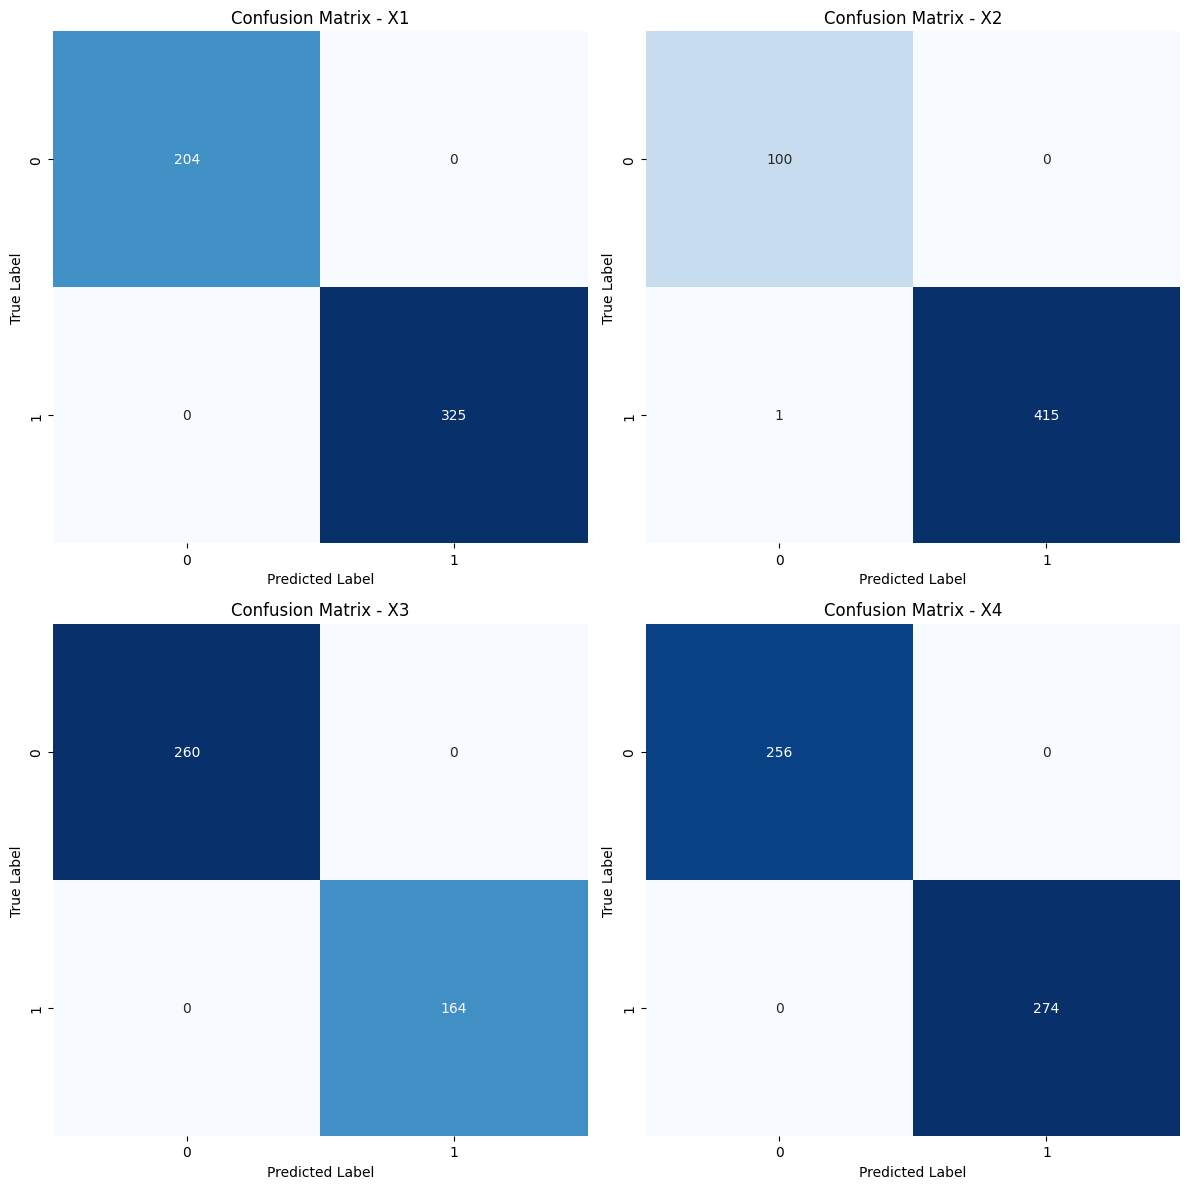

In [53]:
def plot_confusion_matrices(y_true_list, y_pred_list, titles, figsize=(12, 12)):
    """
    Plots confusion matrices in a 2x2 grid.

    Parameters:
    y_true_list (list): List of true labels for each dataset.
    y_pred_list (list): List of predicted labels for each dataset.
    titles (list): List of titles for each subplot.
    figsize (tuple): Size of the figure.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    for i, (y_true, y_pred, title) in enumerate(zip(y_true_list, y_pred_list, titles)):
        row, col = divmod(i, 2)
        conf_mat = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
        axes[row, col].set_xlabel('Predicted Label')
        axes[row, col].set_ylabel('True Label')
        axes[row, col].set_title(title)
    
    plt.tight_layout()
    plt.show()

# True labels and predicted labels for each dataset
y_true_list = [y1_train, y2_train, y3_train, y4_train]
y_pred_list = [pred_trainX1_rf, pred_trainX2_rf, pred_trainX3_rf, pred_trainX4_rf]
titles = ['Confusion Matrix - X1', 'Confusion Matrix - X2', 'Confusion Matrix - X3', 'Confusion Matrix - X4']

# Plot the confusion matrices
plot_confusion_matrices(y_true_list, y_pred_list, titles)

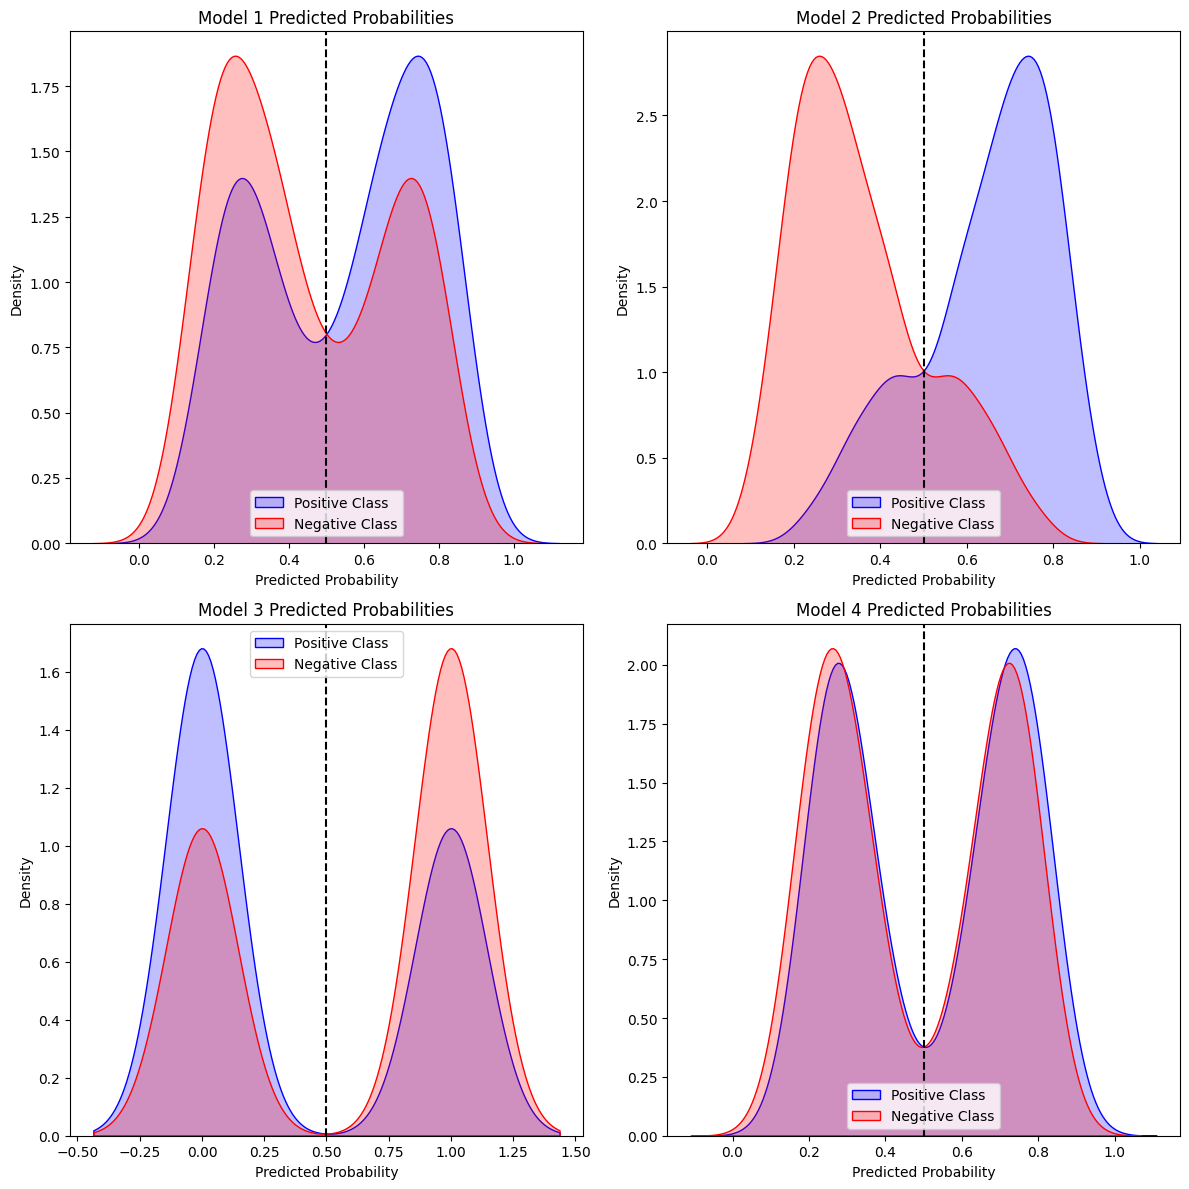

In [41]:
# Plot Predicted Probabilities

def plot_predicted_probabilities(models, X_train_list, titles, figsize=(12, 12)):
    """
    Plot predicted probabilities for four models in a 2x2 grid.

    Parameters:
    models (list of estimators): List of trained models.
    X_train_list (list of array-like): List of training datasets for each model.
    titles (list of str): List of titles for each subplot.
    figsize (tuple): Figure size.
    """
    if len(models) != 4 or len(X_train_list) != 4 or len(titles) != 4:
        raise ValueError("All input lists must have exactly 4 elements.")
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    for i, (model, X_train, title) in enumerate(zip(models, X_train_list, titles)):
        row, col = divmod(i, 2)
        y_train_pred_prob_pos = model.predict_proba(X_train)[:, 1]
        y_train_pred_prob_neg = model.predict_proba(X_train)[:, 0]
        
        sns.kdeplot(y_train_pred_prob_pos, fill=True, color='b', label='Positive Class', ax=axes[row, col])
        sns.kdeplot(y_train_pred_prob_neg, fill=True, color='r', label='Negative Class', ax=axes[row, col])
    
        axes[row, col].axvline(0.5, color='k', linestyle='--')
        axes[row, col].set_xlabel('Predicted Probability')
        axes[row, col].set_ylabel('Density')
        axes[row, col].set_title(title)
        axes[row, col].legend()
   
    plt.tight_layout()
    plt.show()

models = [rf_final1, rf_final2, rf_final3, rf_final4]
X_train_list = [X1_train, X2_train, X3_train, X4_train]
titles = ['Model 1 Predicted Probabilities', 'Model 2 Predicted Probabilities', 
          'Model 3 Predicted Probabilities', 'Model 4 Predicted Probabilities']

# Plot the predicted probabilities
plot_predicted_probabilities(models, X_train_list, titles) 



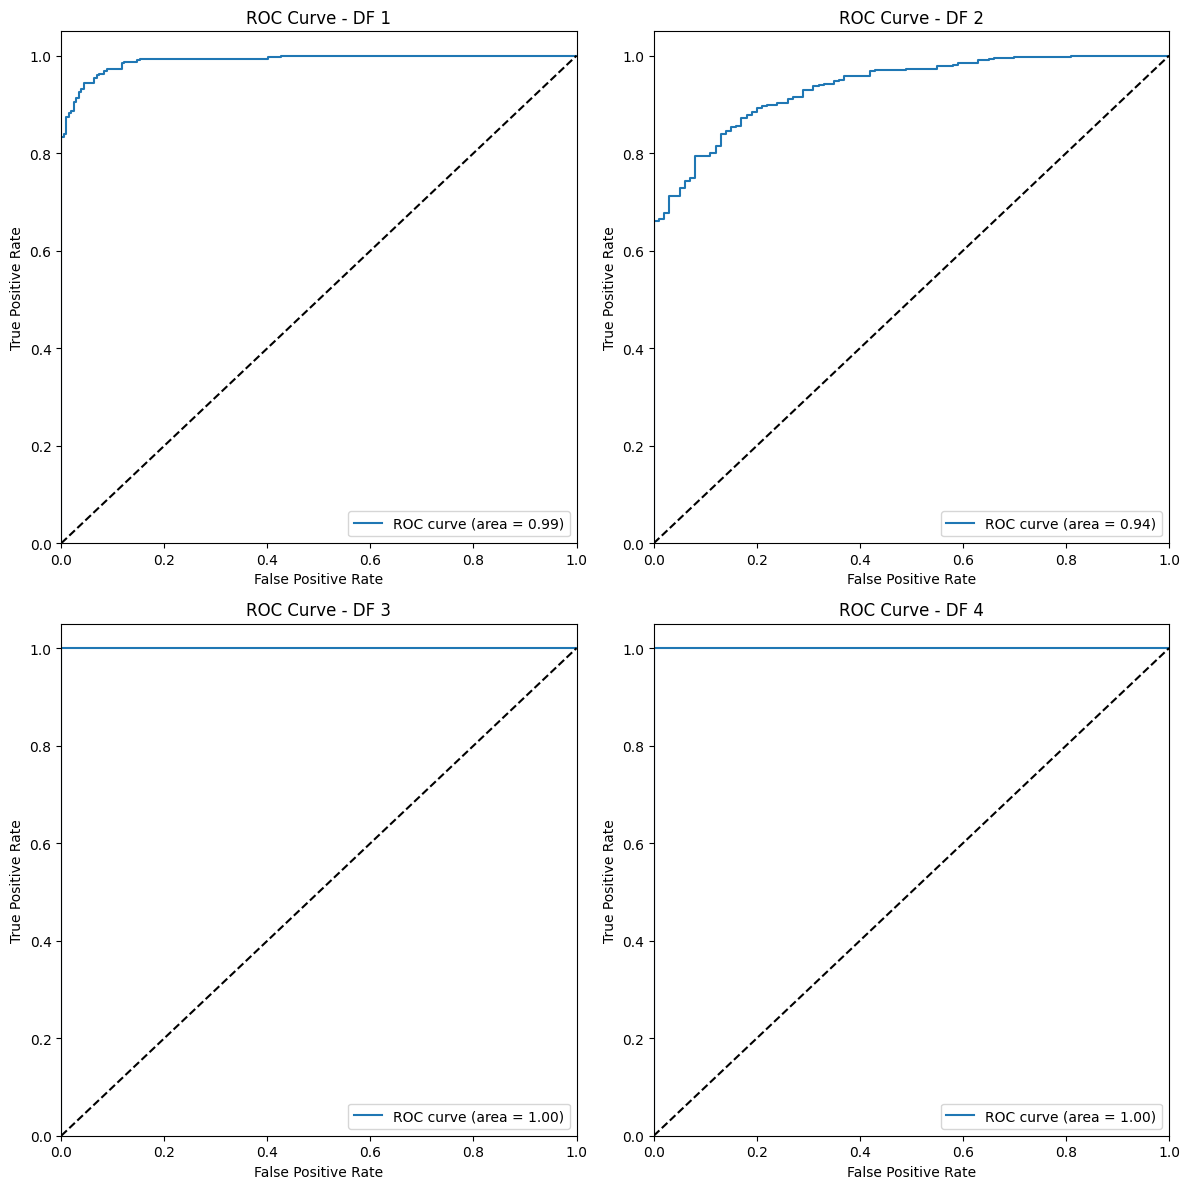

In [48]:
# Plot ROC Curve

def plot_roc_curves(y_true_list, y_pred_probs_list, model_names):
    """
    Plot ROC curves for four models in a 2x2 grid.

    Parameters:
    y_true_list (list of array-like): List of true labels for each model.
    y_pred_probs_list (list of array-like): List of predicted probabilities for each model.
    model_names (list of str): List of model names.
    """
    if len(y_true_list) != 4 or len(y_pred_probs_list) != 4 or len(model_names) != 4:
        raise ValueError("All input lists must have exactly 4 elements.")
    
    plt.figure(figsize=(12, 12))
    
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        fpr, tpr, _ = roc_curve(y_true_list[i], y_pred_probs_list[i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_names[i]}')
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Example usage:
y_true_list = [y1_train, y2_train, y3_train, y4_train]
y_pred_probs = [rf_final1.predict_proba(X1_train)[:,1], 
                rf_final2.predict_proba(X2_train)[:,1], 
                rf_final3.predict_proba(X3_train)[:,1], 
                rf_final4.predict_proba(X4_train)[:,1]]
model_names = ['DF 1', 'DF 2', 'DF 3', 'DF 4']
plot_roc_curves(y_true_list, y_pred_probs, model_names)



### Fit on Unseen Data

In [78]:
# Predict on the Unseen Data
pred_testX1_rf = rf_final1.predict(X1_test)
pred_testX2_rf = rf_final2.predict(X2_test)
pred_testX3_rf = rf_final3.predict(X3_test)
pred_testX4_rf = rf_final4.predict(X4_test)

In [79]:
# Evaluate Model on Unseen Data
print("DATA FRAME 1")
print(f"Accuracy: {accuracy_score(y1_test, pred_testX1_rf)}")
print(f"F1 Macro Score: {f1_score(y1_test, pred_testX1_rf, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_testX1_rf)}")
print()

print("DATA FRAME 2")
print(f"Accuracy: {accuracy_score(y2_test, pred_testX2_rf)}")
print(f"F1 Macro Score: {f1_score(y2_test, pred_testX2_rf, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y2_test, pred_testX2_rf)}")
print()

print("DATA FRAME 3")
print(f"Accuracy: {accuracy_score(y3_test, pred_testX3_rf)}")
print(f"F1 Macro Score: {f1_score(y3_test, pred_testX3_rf, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y3_test, pred_testX3_rf)}")
print()

print("DATA FRAME 4")
print(f"Accuracy: {accuracy_score(y4_test, pred_testX4_rf)}")
print(f"F1 Macro Score: {f1_score(y4_test, pred_testX4_rf, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y4_test, pred_testX4_rf)}")

DATA FRAME 1
Accuracy: 0.6165413533834586
F1 Macro Score: 0.5644384511654787
ROC AUC Score: 0.5717299578059072

DATA FRAME 2
Accuracy: 0.7364341085271318
F1 Macro Score: 0.5905526512322629
ROC AUC Score: 0.5851724137931034

DATA FRAME 3
Accuracy: 0.5849056603773585
F1 Macro Score: 0.5076013513513513
ROC AUC Score: 0.5420289855072464

DATA FRAME 4
Accuracy: 0.5864661654135338
F1 Macro Score: 0.5841150719199499
ROC AUC Score: 0.5847031963470319


In [80]:
# Evaluate Model on Unseen Data (Table)
metrics_rf_test = {
    'Model': ['X1', 'X1', 'X1', 'X2', 'X2', 'X2', 'X3', 'X3', 'X3', 'X4', 'X4', 'X4'],
    'Metric': ['Accuracy', 'F1 Score', 'ROC AUC Score'] * 4,
    'Value': [
        accuracy_score(y1_test, pred_testX1_rf),
        f1_score(y1_test, pred_testX1_rf, average='macro'),
        roc_auc_score(y1_test, pred_testX1_rf),
        
        accuracy_score(y2_test, pred_testX2_rf),
        f1_score(y2_test, pred_testX2_rf, average='macro'),
        roc_auc_score(y2_test, pred_testX2_rf),

        accuracy_score(y3_test, pred_testX3_rf),
        f1_score(y3_test, pred_testX3_rf, average='macro'),
        roc_auc_score(y3_test, pred_testX3_rf),

        accuracy_score(y4_test, pred_testX4_rf),
        f1_score(y4_test, pred_testX4_rf, average='macro'),
        roc_auc_score(y4_test, pred_testX4_rf)
    ]
}

# Create a DataFrame
metrics_rf_test_df = pd.DataFrame(metrics_rf_test)

# Display the DataFrame
metrics_rf_test_df

Model         Metric     Value
0     X1       Accuracy  0.616541
1     X1       F1 Score  0.564438
2     X1  ROC AUC Score  0.571730
3     X2       Accuracy  0.736434
4     X2       F1 Score  0.590553
5     X2  ROC AUC Score  0.585172
6     X3       Accuracy  0.584906
7     X3       F1 Score  0.507601
8     X3  ROC AUC Score  0.542029
9     X4       Accuracy  0.586466
10    X4       F1 Score  0.584115
11    X4  ROC AUC Score  0.584703

In [ ]:
# Plot ROC curves
y_true_list = [y1_test, y2_test, y3_test, y4_test]
y_pred_probs = [rf_final1.predict_proba(X1_test)[:,1], 
                rf_final2.predict_proba(X2_test)[:,1], 
                rf_final3.predict_proba(X3_test)[:,1], 
                rf_final4.predict_proba(X4_test)[:,1]]
model_names = ['DF 1 - Random Forest', 'DF 2 - Random Forest', 'DF 3 - Random Forest', 'DF 4 - Random Forest']
plot_roc_curves(y_true_list, y_pred_probs, model_names)

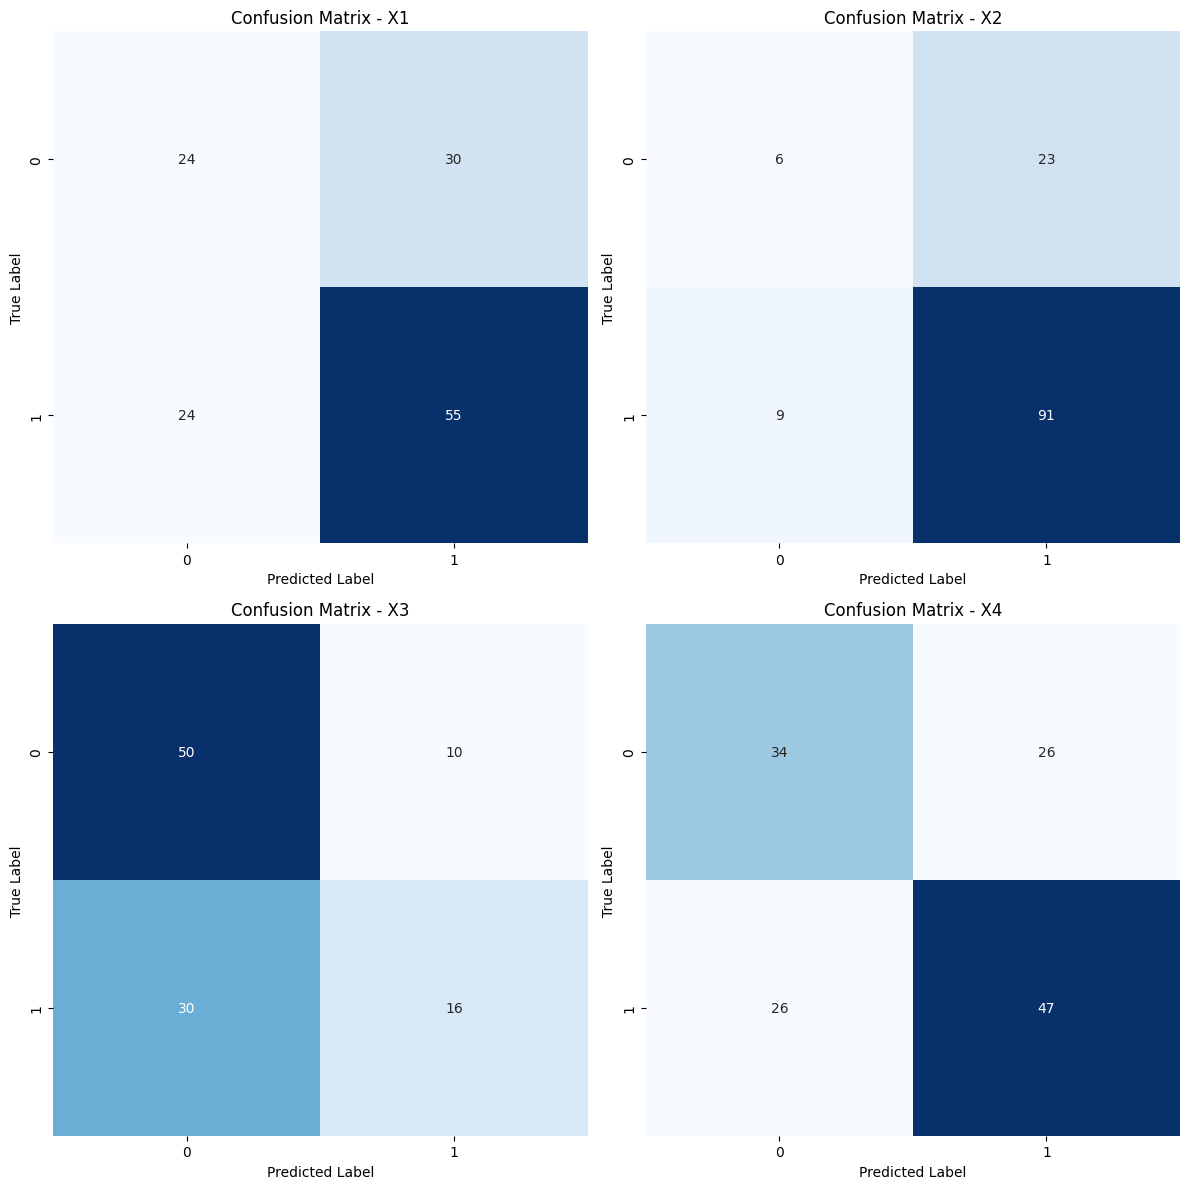

In [30]:
# Plot the confusion matrices
y_true_list = [y1_test, y2_test, y3_test, y4_test]
y_pred_list = [pred_testX1_rf, pred_testX2_rf, pred_testX3_rf, pred_testX4_rf]
titles = ['Confusion Matrix - X1', 'Confusion Matrix - X2', 'Confusion Matrix - X3', 'Confusion Matrix - X4']

plot_confusion_matrices(y_true_list, y_pred_list, titles)

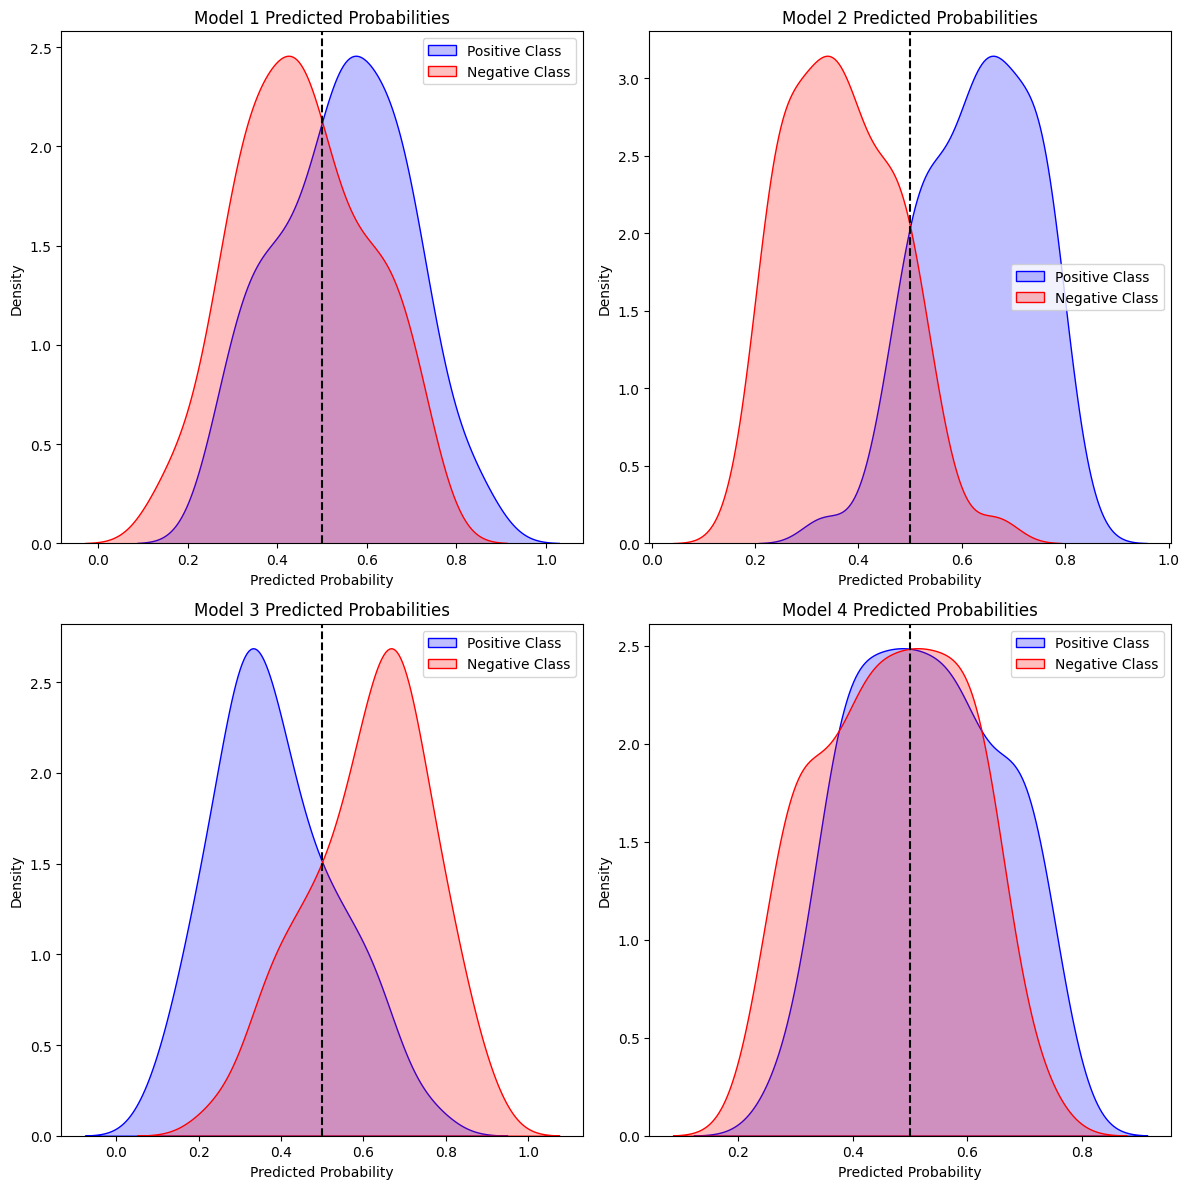

In [31]:
# Plot the predicted probabilities distributions
models = [rf_final1, rf_final2, rf_final3, rf_final4]
X_test_list = [X1_test, X2_test, X3_test, X4_test]
titles = ['Model 1 Predicted Probabilities', 'Model 2 Predicted Probabilities', 
          'Model 3 Predicted Probabilities', 'Model 4 Predicted Probabilities']

plot_predicted_probabilities(models, X_test_list, titles)

### Hyperparameter: Grid Search

In [78]:
# Hyperparmeter Tuning - Grid Search 1st Iteration
param_grid1 = {
    'n_estimators': [50, 100, 200, 300, 500, 1000, 1250, 1500, 1750, 2000], # Number of trees in the forest.
    'max_depth': [2, 5, 10, 20, 30, 40],                                    # Maximum depth of each tree.
    'min_samples_split': [2, 5, 10, 20, 30, 35]                             # Minimum number of samples to split a node.
}

# Set up the first GridSearchCV
grid_search = GridSearchCV(model_rf, param_grid1,
                            scoring='roc_auc',
                            refit='roc_auc',
                            cv=7,
                            verbose=2,
                            n_jobs=4)

# Perform the first Grid Search
grid_searchX1_1st = grid_search.fit(X1_train, y1_train)
#grid_searchX2_1st = grid_search.fit(X2_train, y2_train)
#grid_searchX3_1st = grid_search.fit(X3_train, y3_train)
#grid_searchX4_1st = grid_search.fit(X4_train, y4_train)

Fitting 7 folds for each of 360 candidates, totalling 2520 fits


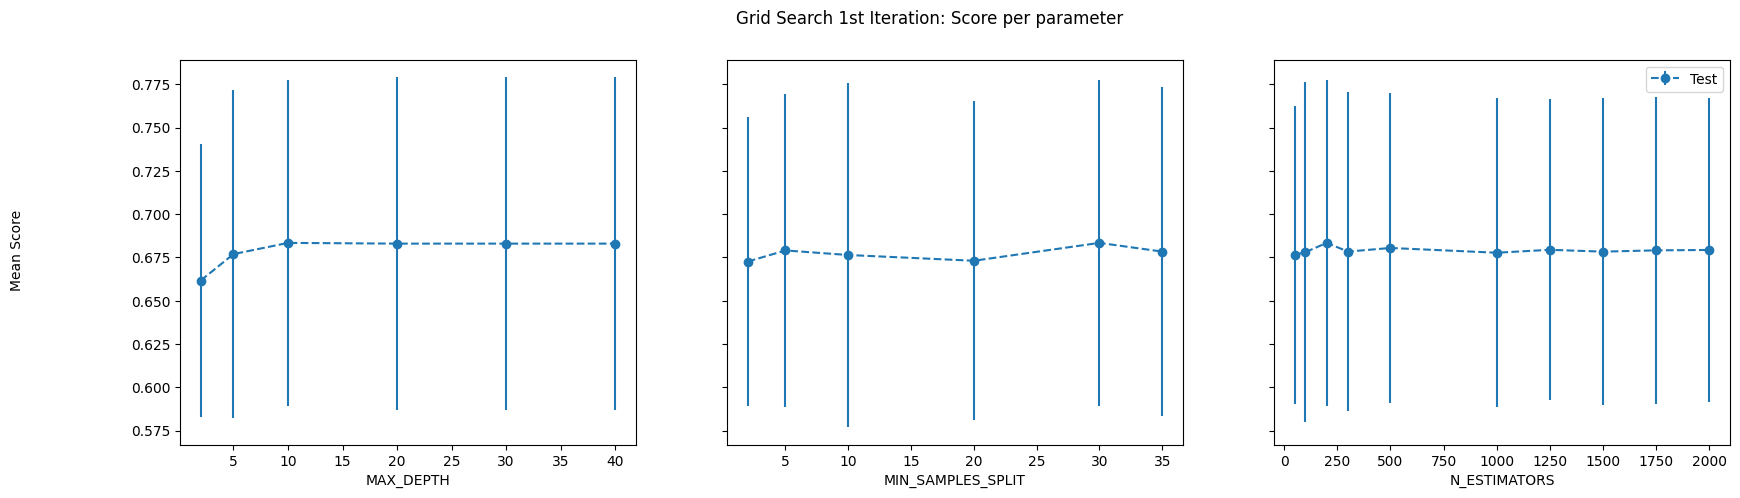

In [80]:
# Results of 1st Grid Search
import numpy as np
import matplotlib.pyplot as plt

def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object (e.g., grid_searchX1_1st).
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results.get('mean_train_score', None)  # In case training scores are not available
    stds_train = results.get('std_train_score', None)

    ## Getting indexes of values per hyper-parameter
    masks = []
    masks_names = list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(np.array(results['param_' + p_k].data) == p_v)

    params = grid.param_grid

    ## Plotting results
    fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=(20, 5))
    fig.suptitle('Grid Search 1st Iteration: Score per parameter')
    fig.text(0.04, 0.5, 'Mean Score', va='center', rotation='vertical')

    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        best_params_mask = m.all(axis=0)
        best_index = np.where(best_params_mask)[0]
        x = np.array(params[p])  # Hyperparameter values for current parameter
        y_1 = np.array(means_test[best_index])  # Test scores
        e_1 = np.array(stds_test[best_index])  # Test score std deviations

        if means_train is not None:
            y_2 = np.array(means_train[best_index])  # Training scores
            e_2 = np.array(stds_train[best_index])  # Training score std deviations
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='Test')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^', label='Train')
        else:
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='Test')

        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

plot_search_results(grid_searchX1_1st)


In [81]:
# Refined Grid
refined_param_grid_X1 = {
    'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000],  # Narrowed based on the initial results
    'max_depth': list(range(4, 11)),
    'min_samples_split': list(range(10, 21))
}

refined_param_grid_X2 = {
    'n_estimators': [50, 300],  # Narrowed based on the initial results
    'max_depth': [2, 20],
    'min_samples_split': [10, 30]
}

refined_param_grid_X3 = {
    'n_estimators': [50, 300],  # Narrowed based on the initial results
    'max_depth': [2, 20],
    'min_samples_split': [10, 30]
}

refined_param_grid_X4 = {
    'n_estimators': [50, 300],  # Narrowed based on the initial results
    'max_depth': [2, 20],
    'min_samples_split': [10, 30]
}


In [82]:
# Hyperparmeter Tuning - Grid Search 2nd Iteration
refined_grid_search = GridSearchCV(model_rf, param_grid = refined_param_grid_X1,
                                   scoring='roc_auc',
                                   refit='roc_auc',
                                   cv=7,
                                   verbose=2,
                                   n_jobs=4)

grid_searchX1_final = refined_grid_search.fit(X_train, y_train)
joblib.dump(grid_searchX1_final, 'grid_searchX1_final.pkl')

print(f"Best parameters from the Random Search: {grid_searchX1_final.best_params_}")
print(f"Best ROC-AUC score from the Random Search: {grid_searchX1_final.best_score_}")

Fitting 7 folds for each of 616 candidates, totalling 4312 fits


c:\Users\chanho\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from the Random Search: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 700}
Best F1 score from the Random Search: 0.6695858633358635


In [31]:
# Fit Final Model with Tuned Hyperparameters
best_params = grid_searchX1_final.best_params_
rf_final1 = RandomForestClassifier(**best_params, random_state=666)

rf_final1.fit(X1_train, y1_train)

# Predict on the test set
pred_testX1_rf = rf_final1.predict(X1_test)

# Evaluate the model using appropriate classification metrics
print(f"Accuracy: {accuracy_score(y1_test, pred_testX1_rf)}")
print(f"F1 Score: {f1_score(y1_test, pred_testX1_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_testX1_rf)}")


Accuracy: 0.6165413533834586
F1 Score: 0.7213114754098361
ROC AUC Score: 0.5658696671354899


## XGBoost

### Hyperparameter: Random Search

In [57]:
distributions = dict(n_estimators = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                     max_depth = list(range(5,21)), 
                     learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])

# Set UP Random Search
scoring = {'roc_auc': 'roc_auc',
           'f1_macro': make_scorer(f1_score, average='macro') }

# Set up the RandomizedSearchCV
search_xgb1 = RandomizedSearchCV(estimator=GradientBoostingClassifier(), verbose=2, scoring= scoring, refit='roc_auc',
                                     param_distributions= distributions, n_iter=100, cv=7, random_state=666, n_jobs=-1)
search_xgb2 = RandomizedSearchCV(estimator=GradientBoostingClassifier(), verbose=2, scoring= scoring, refit='roc_auc',
                                     param_distributions= distributions, n_iter=100, cv=7, random_state=666, n_jobs=-1)
search_xgb3 = RandomizedSearchCV(estimator=GradientBoostingClassifier(), verbose=2, scoring= scoring, refit='roc_auc',
                                     param_distributions= distributions, n_iter=100, cv=7, random_state=666, n_jobs=-1)
search_xgb4 = RandomizedSearchCV(estimator=GradientBoostingClassifier(), verbose=2, scoring= scoring, refit='roc_auc',
                                     param_distributions= distributions, n_iter=100, cv=7, random_state=666, n_jobs=-1)

In [ ]:
# Run the search

search_xgb1.fit(X1_train, y1_train)
joblib.dump(search_xgb1, 'search_xgb1.pkl')
print(f"X1's Best parameters from the Random Search: {search_xgb1.best_params_}")
print(f"X1's Best ROC-AUC score from the Random Search: {search_xgb1.best_score_}")
print(f"X1's Best F1 macro score from the Random Search: {max(search_xgb1.cv_results_['mean_test_f1_macro'])}")
print()

search_xgb2.fit(X2_train, y2_train)
joblib.dump(search_xgb2, 'search_xgb2.pkl')
print(f"X2's Best parameters from the Random Search: {search_xgb2.best_params_}")
print(f"X2's Best ROC-AUC score from the Random Search: {search_xgb2.best_score_}")
print(f"X2's Best F1 macro score from the Random Search: {max(search_xgb2.cv_results_['mean_test_f1_macro'])}")
print()

search_xgb3.fit(X3_train, y3_train)
joblib.dump(search_xgb3, 'search_xgb3.pkl')
print(f"X3's Best parameters from the Random Search: {search_xgb3.best_params_}")
print(f"X3's Best ROC-AUC score from the Random Search: {search_xgb3.best_score_}")
print(f"X3's Best F1 macro score from the Random Search: {max(search_xgb3.cv_results_['mean_test_f1_macro'])}")
print()

search_xgb4.fit(X4_train, y4_train)
joblib.dump(search_xgb4, 'search_xgb4.pkl')
print(f"X4's Best parameters from the Random Search: {search_xgb4.best_params_}")
print(f"X4's Best ROC-AUC score from the Random Search: {search_xgb4.best_score_}")
print(f"X4's Best F1 macro score from the Random Search: {max(search_xgb4.cv_results_['mean_test_f1_macro'])}")

In [32]:
# Load up the Fitted RandomizedSearchCV objects

search_xgb1 = joblib.load('pickles/search_xgb1.pkl')
search_xgb2 = joblib.load('pickles/search_xgb2.pkl')
search_xgb3 = joblib.load('pickles/search_xgb3.pkl')
search_xgb4 = joblib.load('pickles/search_xgb4.pkl')

### Select Best

In [81]:
# Select Best parameters and Fit Final Model
best_params_xgb_X1 = search_xgb1.best_params_
xgb_final1 = GradientBoostingClassifier(**best_params_xgb_X1, random_state=666)
xgb_final1.fit(X1_train, y1_train)
pred_trainX1_xgb = xgb_final1.predict(X1_train)

best_params_xgb_X2 = search_xgb2.best_params_
xgb_final2 = GradientBoostingClassifier(**best_params_xgb_X2, random_state=666)
xgb_final2.fit(X2_train, y2_train)
pred_trainX2_xgb = xgb_final2.predict(X2_train)

best_params_xgb_X3 = search_xgb3.best_params_
xgb_final3 = GradientBoostingClassifier(**best_params_xgb_X3, random_state=666)
xgb_final3.fit(X3_train, y3_train)
pred_trainX3_xgb = xgb_final3.predict(X3_train)

best_params_xgb_X4 = search_xgb4.best_params_
xgb_final4 = GradientBoostingClassifier(**best_params_xgb_X4, random_state=666)
xgb_final4.fit(X4_train, y4_train)
pred_trainX4_xgb = xgb_final4.predict(X4_train)

In [82]:
# Evaluate the model
print(f"X1's Accuracy: {accuracy_score(y1_train, pred_trainX1_xgb)}")
print(f"X1's F1 Macro Score: {f1_score(y1_train, pred_trainX1_xgb, average='macro')}")
print(f"X1's ROC AUC Score: {roc_auc_score(y1_train, pred_trainX1_xgb)}")
print()

print(f"X2's Accuracy: {accuracy_score(y2_train, pred_trainX2_xgb)}")
print(f"X2's F1 Macro Score: {f1_score(y2_train, pred_trainX2_xgb, average='macro')}")
print(f"X2's ROC AUC Score: {roc_auc_score(y2_train, pred_trainX2_xgb)}")
print()

print(f"X3's Accuracy: {accuracy_score(y3_train, pred_trainX3_xgb)}")
print(f"X3's F1 Macro Score: {f1_score(y3_train, pred_trainX3_xgb, average='macro')}")
print(f"X3's ROC AUC Score: {roc_auc_score(y3_train, pred_trainX3_xgb)}")
print()

print(f"X4's Accuracy: {accuracy_score(y4_train, pred_trainX4_xgb)}")
print(f"X4's F1 Macro Score: {f1_score(y4_train, pred_trainX4_xgb, average='macro')}")
print(f"X4's ROC AUC Score: {roc_auc_score(y4_train, pred_trainX4_xgb)}")

X1's Accuracy: 1.0
X1's F1 Macro Score: 1.0
X1's ROC AUC Score: 1.0

X2's Accuracy: 1.0
X2's F1 Macro Score: 1.0
X2's ROC AUC Score: 1.0

X3's Accuracy: 1.0
X3's F1 Macro Score: 1.0
X3's ROC AUC Score: 1.0

X4's Accuracy: 1.0
X4's F1 Macro Score: 1.0
X4's ROC AUC Score: 1.0


In [83]:
# Create a DataFrame to store the metrics
metrics_xgb_train = {
    'Model': ['X1', 'X1', 'X1', 'X2', 'X2', 'X2', 'X3', 'X3', 'X3', 'X4', 'X4', 'X4'],
    'Metric': ['Accuracy', 'F1 Score', 'ROC AUC Score'] * 4,
    'Value': [
        accuracy_score(y1_train, pred_trainX1_xgb),
        f1_score(y1_train, pred_trainX1_xgb, average='macro'),
        roc_auc_score(y1_train, pred_trainX1_xgb),
        accuracy_score(y2_train, pred_trainX2_xgb),
        f1_score(y2_train, pred_trainX2_xgb, average='macro'),
        roc_auc_score(y2_train, pred_trainX2_xgb),
        accuracy_score(y3_train, pred_trainX3_xgb),
        f1_score(y3_train, pred_trainX3_xgb, average='macro'),
        roc_auc_score(y3_train, pred_trainX3_xgb),
        accuracy_score(y4_train, pred_trainX4_xgb),
        f1_score(y4_train, pred_trainX4_xgb, average='macro'),
        roc_auc_score(y4_train, pred_trainX4_xgb)
    ]
}

# Create a DataFrame
metrics_xgb_train_df = pd.DataFrame(metrics_xgb_train)

# Display the DataFrame
metrics_xgb_train_df

Model         Metric  Value
0     X1       Accuracy    1.0
1     X1       F1 Score    1.0
2     X1  ROC AUC Score    1.0
3     X2       Accuracy    1.0
4     X2       F1 Score    1.0
5     X2  ROC AUC Score    1.0
6     X3       Accuracy    1.0
7     X3       F1 Score    1.0
8     X3  ROC AUC Score    1.0
9     X4       Accuracy    1.0
10    X4       F1 Score    1.0
11    X4  ROC AUC Score    1.0

### Plot Model's Metrics

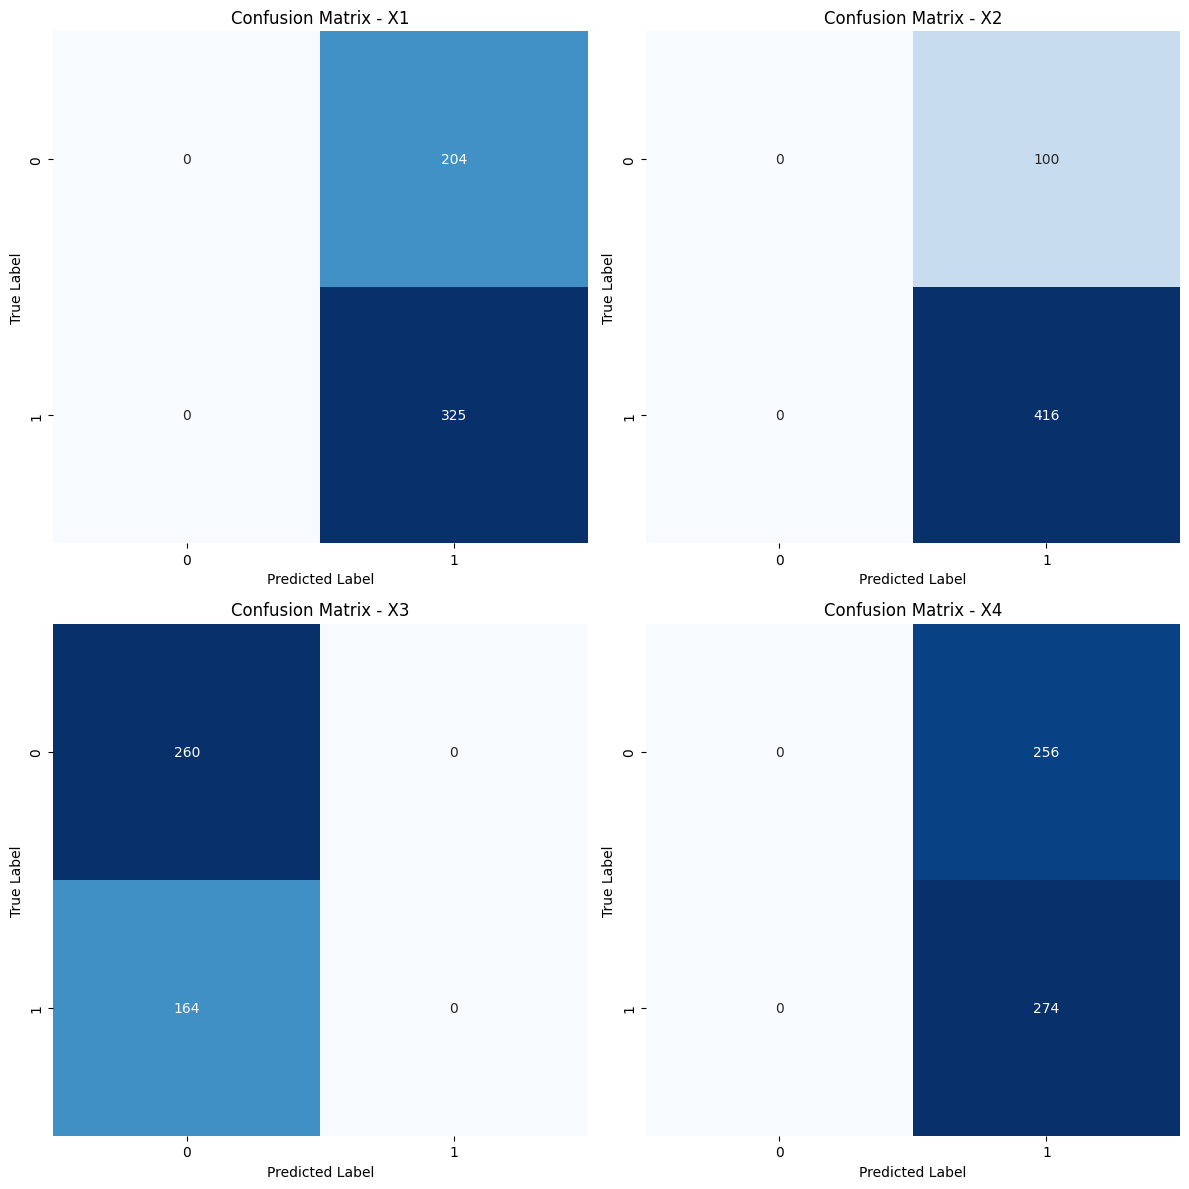

In [20]:
# Plot Conusion Matrix
def plot_confusion_matrices(y_true_list, y_pred_list, titles, figsize=(12, 12)):
    """
    Plots confusion matrices in a 2x2 grid.

    Parameters:
    y_true_list (list): List of true labels for each dataset.
    y_pred_list (list): List of predicted labels for each dataset.
    titles (list): List of titles for each subplot.
    figsize (tuple): Size of the figure.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    for i, (y_true, y_pred, title) in enumerate(zip(y_true_list, y_pred_list, titles)):
        row, col = divmod(i, 2)
        conf_mat = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
        axes[row, col].set_xlabel('Predicted Label')
        axes[row, col].set_ylabel('True Label')
        axes[row, col].set_title(title)
    
    plt.tight_layout()
    plt.show()

# True labels and predicted labels for each dataset
y_true_list = [y1_train, y2_train, y3_train, y4_train]
y_pred_list = [pred_trainX1_xgb, pred_trainX2_xgb, pred_trainX3_xgb, pred_trainX4_xgb]
titles = ['Confusion Matrix - X1', 'Confusion Matrix - X2', 'Confusion Matrix - X3', 'Confusion Matrix - X4']

# Plot the confusion matrices
plot_confusion_matrices(y_true_list, y_pred_list, titles)

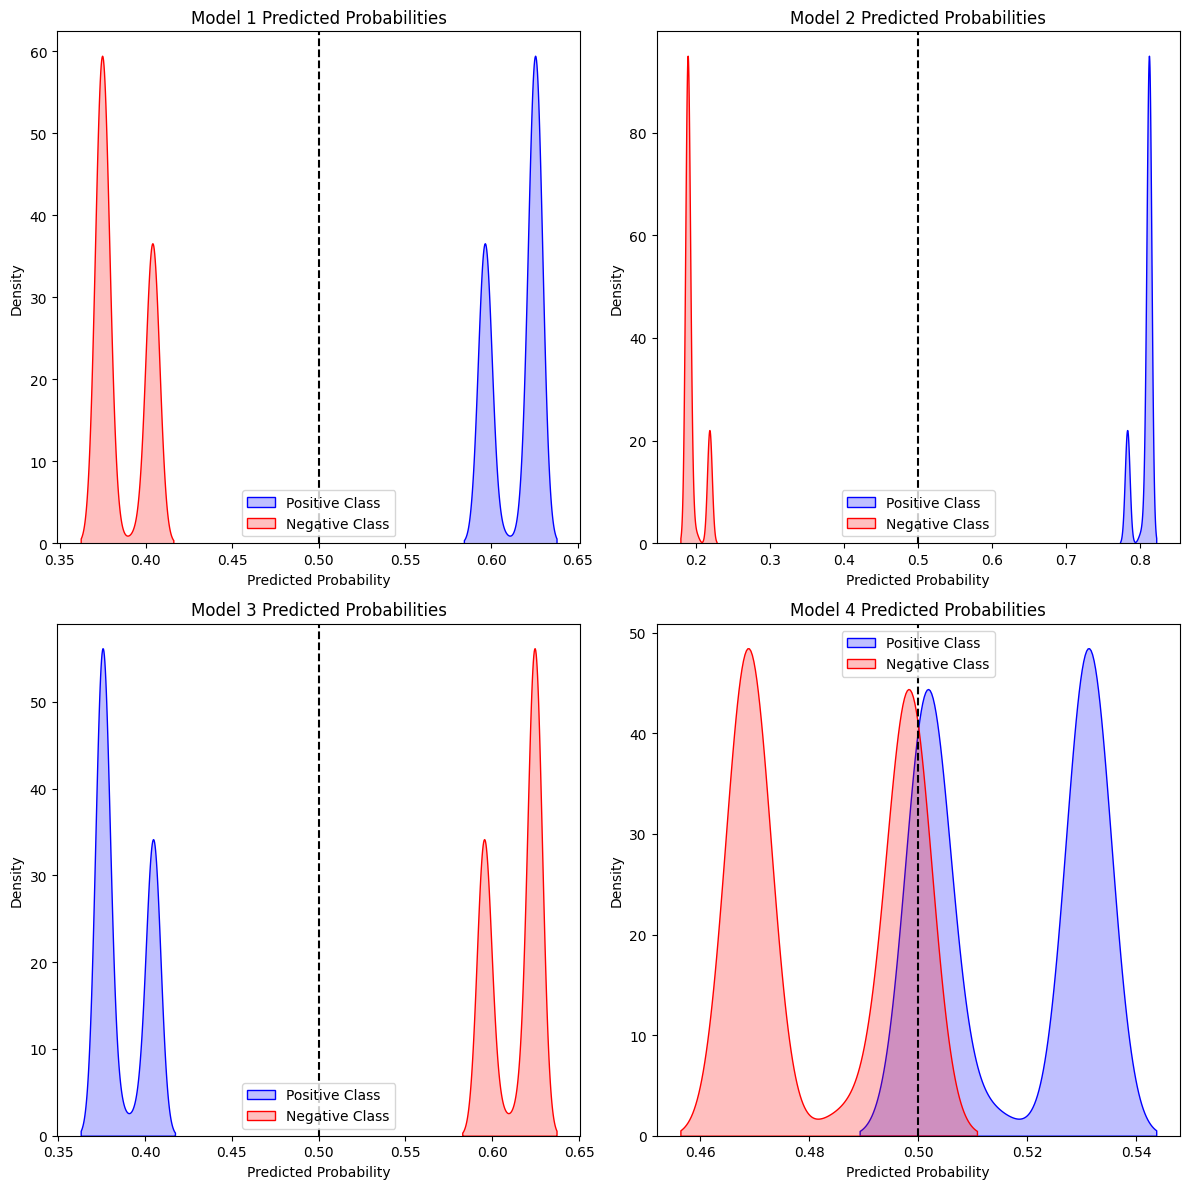

In [21]:
# Plot Predicted Probabilities

def plot_predicted_probabilities(models, X_train_list, titles, figsize=(12, 12)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    for i, (model, X_train, title) in enumerate(zip(models, X_train_list, titles)):
        row, col = divmod(i, 2)
        y_train_pred_prob_pos = model.predict_proba(X_train)[:, 1]
        y_train_pred_prob_neg = model.predict_proba(X_train)[:, 0]
        
        sns.kdeplot(y_train_pred_prob_pos, fill=True, color='b', label='Positive Class', ax=axes[row, col])
        sns.kdeplot(y_train_pred_prob_neg, fill=True, color='r', label='Negative Class', ax=axes[row, col])
    
        axes[row, col].axvline(0.5, color='k', linestyle='--')
        axes[row, col].set_xlabel('Predicted Probability')
        axes[row, col].set_ylabel('Density')
        axes[row, col].set_title(title)
        axes[row, col].legend()
   
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have four trained models and their corresponding training datasets
models = [xgb_final1, xgb_final2, xgb_final3, xgb_final4]
X_train_list = [X1_train, X2_train, X3_train, X4_train]
titles = ['Model 1 Predicted Probabilities', 'Model 2 Predicted Probabilities', 
          'Model 3 Predicted Probabilities', 'Model 4 Predicted Probabilities']

# Plot the predicted probabilities
plot_predicted_probabilities(models, X_train_list, titles) 



### Fit on Unseen Data

In [84]:
# Predict on the Unseen Data
pred_testX1_xgb = xgb_final1.predict(X1_test)
pred_testX2_xgb = xgb_final2.predict(X2_test)
pred_testX3_xgb = xgb_final3.predict(X3_test)
pred_testX4_xgb = xgb_final4.predict(X4_test)

In [85]:
# Evaluate Model on Unseen Data
print("DATA FRAME 1")
print(f"Accuracy: {accuracy_score(y1_test, pred_testX1_xgb)}")
print(f"F1 Macro Score: {f1_score(y1_test, pred_testX1_xgb, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_testX1_xgb)}")
print()

print("DATA FRAME 2")
print(f"Accuracy: {accuracy_score(y2_test, pred_testX2_xgb)}")
print(f"F1 Macro Score: {f1_score(y2_test, pred_testX2_xgb, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y2_test, pred_testX2_xgb)}")
print()

print("DATA FRAME 3")
print(f"Accuracy: {accuracy_score(y3_test, pred_testX3_xgb)}")
print(f"F1 Macro Score: {f1_score(y3_test, pred_testX3_xgb, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y3_test, pred_testX3_xgb)}")
print()

print("DATA FRAME 4")
print(f"Accuracy: {accuracy_score(y4_test, pred_testX4_xgb)}")
print(f"F1 Macro Score: {f1_score(y4_test, pred_testX4_xgb, average='macro')}")
print(f"ROC AUC Score: {roc_auc_score(y4_test, pred_testX4_xgb)}")

DATA FRAME 1
Accuracy: 0.5939849624060151
F1 Macro Score: 0.5599264705882353
ROC AUC Score: 0.5615330520393811

DATA FRAME 2
Accuracy: 0.7596899224806202
F1 Macro Score: 0.4876361306854581
ROC AUC Score: 0.5144827586206896

DATA FRAME 3
Accuracy: 0.6226415094339622
F1 Macro Score: 0.6022514071294559
ROC AUC Score: 0.6032608695652174

DATA FRAME 4
Accuracy: 0.556390977443609
F1 Macro Score: 0.552750071245369
ROC AUC Score: 0.5528538812785387


In [86]:
# Create a DataFrame to store the metrics
metrics_xgb_test = {
    'Model': ['X1', 'X1', 'X1', 'X2', 'X2', 'X2', 'X3', 'X3', 'X3', 'X4', 'X4', 'X4'],
    'Metric': ['Accuracy', 'F1 Score', 'ROC AUC Score'] * 4,
    'Value': [
        accuracy_score(y1_test, pred_testX1_xgb),
        f1_score(y1_test, pred_testX1_xgb, average='macro'),
        roc_auc_score(y1_test, pred_testX1_xgb),
        accuracy_score(y2_test, pred_testX2_xgb),
        f1_score(y2_test, pred_testX2_xgb, average='macro'),
        roc_auc_score(y2_test, pred_testX2_xgb),
        accuracy_score(y3_test, pred_testX3_xgb),
        f1_score(y3_test, pred_testX3_xgb, average='macro'),
        roc_auc_score(y3_test, pred_testX3_xgb),
        accuracy_score(y4_test, pred_testX4_xgb),
        f1_score(y4_test, pred_testX4_xgb, average='macro'),
        roc_auc_score(y4_test, pred_testX4_xgb)
    ]
}

# Create a DataFrame
metrics_xgb_test_df = pd.DataFrame(metrics_xgb_test)

# Display the DataFrame
metrics_xgb_test_df

Model         Metric     Value
0     X1       Accuracy  0.593985
1     X1       F1 Score  0.559926
2     X1  ROC AUC Score  0.561533
3     X2       Accuracy  0.759690
4     X2       F1 Score  0.487636
5     X2  ROC AUC Score  0.514483
6     X3       Accuracy  0.622642
7     X3       F1 Score  0.602251
8     X3  ROC AUC Score  0.603261
9     X4       Accuracy  0.556391
10    X4       F1 Score  0.552750
11    X4  ROC AUC Score  0.552854

In [58]:
# Plot ROC curves
y_true_list = [y1_test, y2_test, y3_test, y4_test]
y_pred_probs = [xgb_final1.predict_proba(X1_test)[:,1], 
                xgb_final2.predict_proba(X2_test)[:,1], 
                xgb_final3.predict_proba(X3_test)[:,1], 
                xgb_final4.predict_proba(X4_test)[:,1]]
model_names = ['DF 1 - XGBoost', 'DF 2 - XGBoost', 'DF 3 - XGBoost', 'DF 4 - XGBoost']

plot_roc_curves(y_true_list, y_pred_probs, model_names)

NameError: name 'plot_roc_curves' is not defined

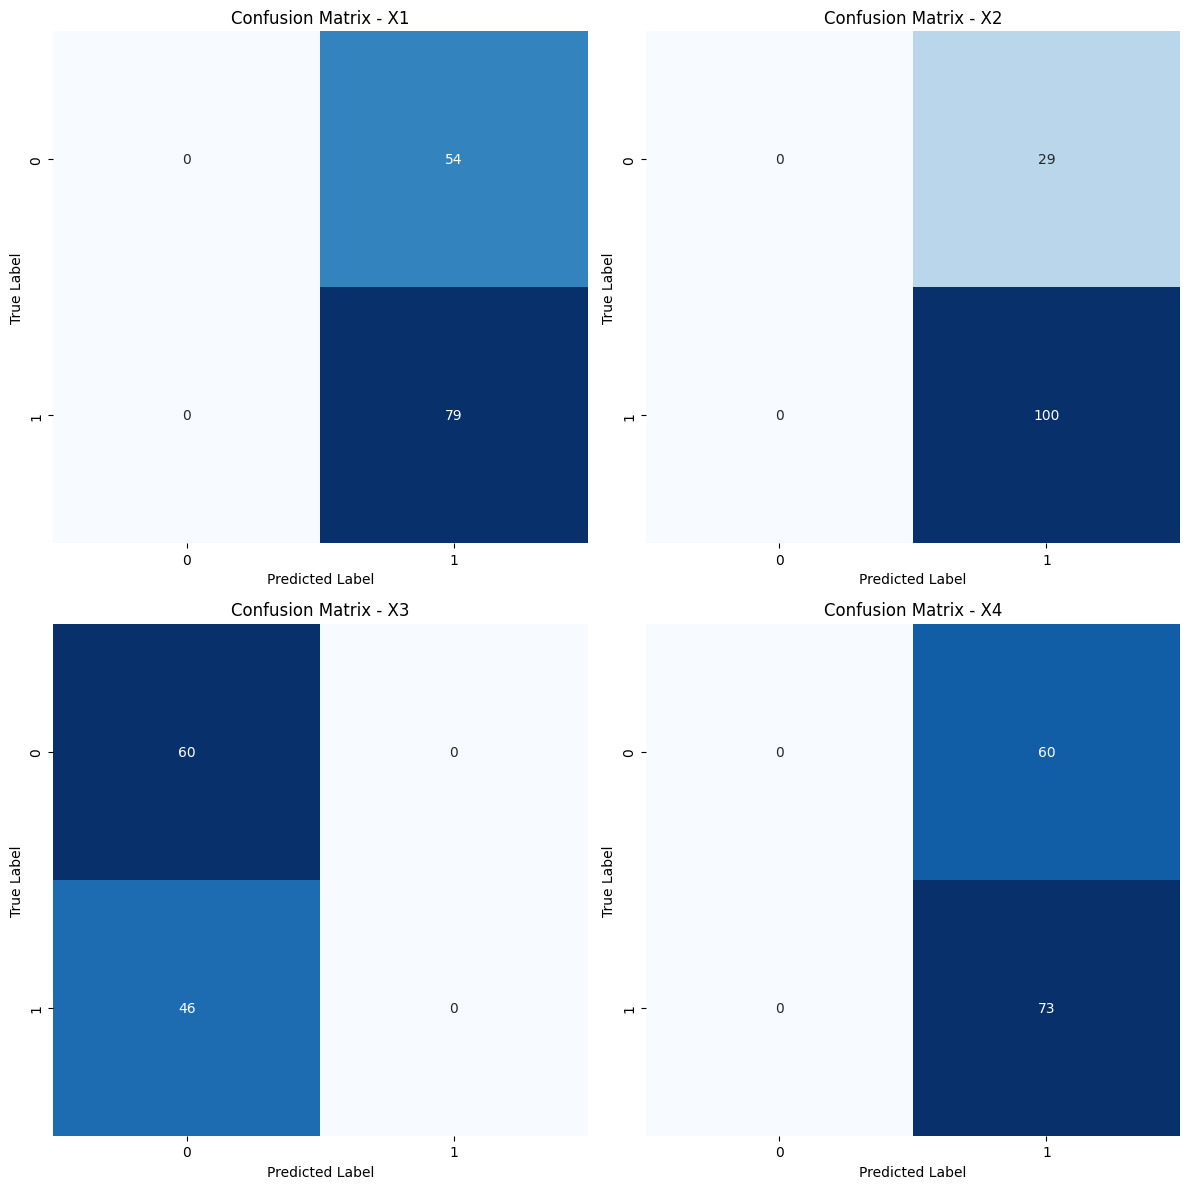

In [39]:
# Plot the confusion matrices
y_true_list = [y1_test, y2_test, y3_test, y4_test]
y_pred_list = [pred_testX1_xgb, pred_testX2_xgb, pred_testX3_xgb, pred_testX4_xgb]
titles = ['Confusion Matrix - X1', 'Confusion Matrix - X2', 'Confusion Matrix - X3', 'Confusion Matrix - X4']

plot_confusion_matrices(y_true_list, y_pred_list, titles)

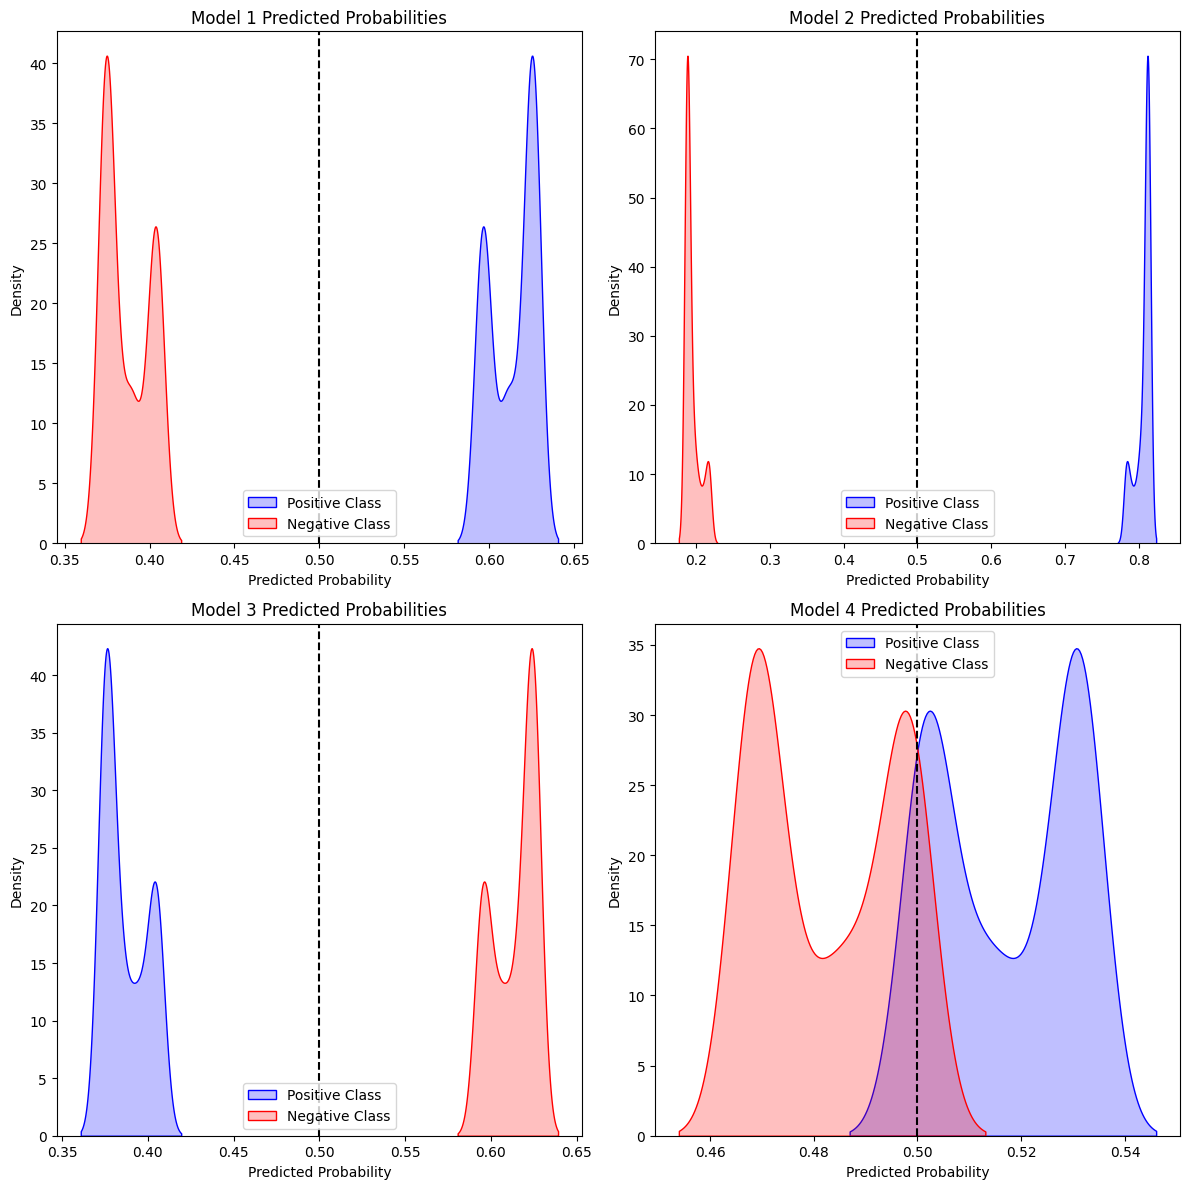

In [40]:
# Plot the predicted probabilities distributions
models = [xgb_final1, xgb_final2, xgb_final3, xgb_final4]
X_test_list = [X1_test, X2_test, X3_test, X4_test]
titles = ['Model 1 Predicted Probabilities', 'Model 2 Predicted Probabilities', 
          'Model 3 Predicted Probabilities', 'Model 4 Predicted Probabilities']

plot_predicted_probabilities(models, X_test_list, titles)

# Model Comparison

## Model Performance on Validation Set

In [64]:
# Extract CV results of Random Forest & XGBoost
def extract_cv_results(search, model_name, cohort_name):
    df = pd.DataFrame(search.cv_results_)[['mean_test_roc_auc', 'mean_test_f1_macro']]
    df['model'] = model_name
    df['cohort'] = cohort_name
    return df

cv_results_rf_X1 = extract_cv_results(random_searchX1, 'Random Forest', 'Coh 1 (Age 27)')
cv_results_rf_X2 = extract_cv_results(random_searchX2, 'Random Forest', 'Coh 2 (Age 27)')
cv_results_rf_X3 = extract_cv_results(random_searchX3, 'Random Forest', 'Coh 2 (Age 37)')
cv_results_rf_X4 = extract_cv_results(random_searchX4, 'Random Forest', 'Coh 3 (Age 37)')

cv_results_xgb_X1 = extract_cv_results(search_xgb1, 'XGBoost', 'Coh 1 (Age 27)')
cv_results_xgb_X2 = extract_cv_results(search_xgb2, 'XGBoost', 'Coh 2 (Age 27)')
cv_results_xgb_X3 = extract_cv_results(search_xgb3, 'XGBoost', 'Coh 2 (Age 37)')
cv_results_xgb_X4 = extract_cv_results(search_xgb4, 'XGBoost', 'Coh 3 (Age 37)')


In [65]:
# Combine CV results
cv_results = pd.concat([cv_results_rf_X1, cv_results_rf_X2, cv_results_rf_X3, cv_results_rf_X4,
                        cv_results_xgb_X1, cv_results_xgb_X2, cv_results_xgb_X3, cv_results_xgb_X4], axis=0)
cv_results = cv_results[['model', 'cohort'] + [col for col in cv_results.columns if col not in ['model', 'cohort']]]
cv_results.reset_index(drop=True, inplace=True)
print(cv_results)

# Melt the DataFrame
cv_results_long = cv_results.melt(id_vars=['model', 'cohort'], 
                                    value_vars=['mean_test_roc_auc', 'mean_test_f1_macro'],
                                    var_name='metric', value_name='score')
cv_results_long['metric'] = cv_results_long['metric'].str.replace('mean_test_roc_auc', 'ROC-AUC')
cv_results_long['metric'] = cv_results_long['metric'].str.replace('mean_test_f1_macro', 'F1-Macro')

print(cv_results_long)

             model          cohort  mean_test_roc_auc  mean_test_f1_macro
0    Random Forest  Coh 1 (Age 27)           0.664801            0.601807
1    Random Forest  Coh 1 (Age 27)           0.673200            0.577005
2    Random Forest  Coh 1 (Age 27)           0.675304            0.617492
3    Random Forest  Coh 1 (Age 27)           0.677266            0.589020
4    Random Forest  Coh 1 (Age 27)           0.670441            0.629435
..             ...             ...                ...                 ...
795        XGBoost  Coh 3 (Age 37)           0.514694            0.514267
796        XGBoost  Coh 3 (Age 37)           0.617514            0.575072
797        XGBoost  Coh 3 (Age 37)           0.527390            0.508580
798        XGBoost  Coh 3 (Age 37)           0.513676            0.504092
799        XGBoost  Coh 3 (Age 37)           0.606246            0.574298

[800 rows x 4 columns]
              model          cohort    metric     score
0     Random Forest  Coh 1 (Age 

In [66]:
# Plot the distribution of CV scores - Box Plot
fig = px.box(cv_results_long, x='cohort', y='score', color='model', 
             facet_col='metric', boxmode='group', 
             title='Distribution of CV Scores for Each Cohort in Random Forest and XGBoost Models')

# Customize the plot
fig.update_layout(xaxis_title='Cohort', yaxis_title='Score')
fig.update_xaxes(tickangle=-45)

# Show the plot
fig.show()

## Model Performance on the Test Set

In [101]:
# Predicted probabilities
y_pred_prob_rf_X1 = rf_final1.predict_proba(X1_test)[:, 1]
y_pred_prob_rf_X2 = rf_final2.predict_proba(X2_test)[:, 1]
y_pred_prob_rf_X3 = rf_final3.predict_proba(X3_test)[:, 1]
y_pred_prob_rf_X4 = rf_final4.predict_proba(X4_test)[:, 1] 

y_pred_prob_xgb_X1 =  xgb_final1.predict_proba(X1_test)[:, 1]
y_pred_prob_xgb_X2 =  xgb_final2.predict_proba(X2_test)[:, 1]
y_pred_prob_xgb_X3 =  xgb_final3.predict_proba(X3_test)[:, 1]
y_pred_prob_xgb_X4 =  xgb_final4.predict_proba(X4_test)[:, 1]


In [103]:
# Plot ROC curves
y_test_list = [y1_test, y2_test, y3_test, y4_test]
y_pred_prob_rf_list = [y_pred_prob_rf_X1, y_pred_prob_rf_X2, y_pred_prob_rf_X3, y_pred_prob_rf_X4]
y_pred_prob_xgb_list = [y_pred_prob_xgb_X1, y_pred_prob_xgb_X2, y_pred_prob_xgb_X3, y_pred_prob_xgb_X4]
cohorts = ['Coh 1 (Age 27)', 
           'Coh 2 (Age 27)', 
           'Coh 2 (Age 37)', 
           'Coh 3 (Age 37)']

# Loop through each dataset and create ROC curve plots
for i, cohort in enumerate(cohorts):
    # Compute ROC curve and AUC for Random Forest
    fpr_rf, tpr_rf, _ = roc_curve(y_test_list[i], y_pred_prob_rf_list[i])
    auc_rf = roc_auc_score(y_test_list[i], y_pred_prob_rf_list[i])
    
    # Compute ROC curve and AUC for XGBoost
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_list[i], y_pred_prob_xgb_list[i])
    auc_xgb = roc_auc_score(y_test_list[i], y_pred_prob_xgb_list[i])
    
    # Create the ROC curve plot for the current dataset
    fig = go.Figure()
    
    # Add Random Forest ROC curve
    fig.add_trace(go.Scatter(x=fpr_rf, y=tpr_rf, mode='lines', name=f'Random Forest {cohort} (AUC = {auc_rf:.2f})'))
    
    # Add XGBoost ROC curve
    fig.add_trace(go.Scatter(x=fpr_xgb, y=tpr_xgb, mode='lines', name=f'XGBoost {cohort} (AUC = {auc_xgb:.2f})'))
    
    # Add diagonal line for reference
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Chance', line=dict(dash='dash')))
    
    # Customize the layout
    fig.update_layout(
        title=f'ROC Curve Comparison for {cohort}',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        legend_title='Model',
        width=800,
        height=600
    )
    
    # Show the plot
    fig.show()

In [ ]:
warm=LinearSegmentedColormap.from_list('warm', 
                                       [(0, '#EBD5C8'), 
                                        (0.25, '#E1C1AD'),
                                        (.75, '#D77873'), 
                                        (1, '#C8504A')], N=256)

models={"Random Forest": rf, "XG Boost": xgb}
# Confusion Matrix
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i, mod in enumerate(models.items()):
    ax = plt.subplot(2, 2, i+1)
    m=list(models.values())[i]
    y_preds=m.predict(X_test_shap)
    cm = confusion_matrix(y_test, y_preds, labels=[1,0])
    classes=['Yes','No']
    label = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    annot = [f'{i}\n\n{j}' for i, j in zip(cm.flatten(), label)]
    annot = np.asarray(annot).reshape(2,2)

    sns.set_context('notebook') 
    ax = sns.heatmap(cm, annot=annot, fmt='', cmap=warm, linecolor='white', linewidths=8)
    ax.set_title(list(models.keys())[i])
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('True Label\n')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

# SHAP Implementation


## Shap Values

In [50]:
# Create the Explainer objects for each X_train
explainer_Kernel1 = shap.KernelExplainer(rf_final1.predict_proba, X1_train) # Kernel explainer
explainer_Tree1 = shap.TreeExplainer(rf_final1, X1_train) # Tree explainer

explainer_Kernel2 = shap.KernelExplainer(rf_final2.predict_proba, X2_train) # Kernel explainer
explainer_Tree2 = shap.TreeExplainer(rf_final2, X2_train) # Tree explainer

explainer_Kernel3 = shap.KernelExplainer(rf_final3.predict_proba, X3_train) # Kernel explainer
explainer_Tree3 = shap.TreeExplainer(rf_final3, X3_train) # Tree explainer

explainer_Kernel4 = shap.KernelExplainer(rf_final4.predict_proba, X4_train) # Kernel explainer
explainer_Tree4 = shap.TreeExplainer(rf_final4, X4_train) # Tree explainer


Using 529 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 516 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 424 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 530 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
explainer_Tree3_xgb = shap.TreeExplainer(xgb_final3, X3_train) # Tree explainer

In [138]:
# Calculate Tree Shap Values
shap_values_Tree1 = explainer_Tree1.shap_values(X1_train)
joblib.dump(shap_values_Tree1, 'shap_values_Tree1.pkl') # Save Shap values

shap_values_Tree2 = explainer_Tree2.shap_values(X2_train, check_additivity=False)
joblib.dump(shap_values_Tree2, 'shap_values_Tree2.pkl') # Save Shap values

shap_values_Tree3 = explainer_Tree3.shap_values(X3_train)
joblib.dump(shap_values_Tree3, 'shap_values_Tree3.pkl') # Save Shap values

shap_values_Tree4 = explainer_Tree4.shap_values(X4_train, check_additivity=False)
joblib.dump(shap_values_Tree4, 'shap_values_Tree4.pkl') # Save Shap values


['shap_values_Tree2.pkl']

In [ ]:
shap_values_Tree3_xgb = explainer_Tree3_xgb.shap_values(X3_train)
joblib.dump(shap_values_Tree3_xgb, 'shap_values_Tree3_xgb.pkl') # Save Shap values

In [6]:
# Load up Shap values
shap_values_Tree1 = joblib.load('pickles/shap_values_Tree1.pkl')
shap_values_Tree2 = joblib.load('pickles/shap_values_Tree2.pkl')
shap_values_Tree3 = joblib.load('pickles/shap_values_Tree3.pkl')
shap_values_Tree4 = joblib.load('pickles/shap_values_Tree4.pkl')

## Recursive Feature Elimination (RFE)

In [139]:
# Custom cross-validation function
def cross_val_scores(model, X_train, y_train, cv=5,
                     metrics=[f1_score, roc_auc_score]):
    
    X_train_re = X_train.reset_index(drop=True)
    y_train_re = y_train.reset_index(drop=True)
    
    kf = KFold(n_splits= cv, random_state = 666, shuffle= True)
    kf.get_n_splits(X_train, y_train)

    scores = [[] for metric in metrics]
    j=1

    for tune_index, eval_index in kf.split(X_train, y_train):
        print(f'Fold {j}')
        model_clone = sklearn.base.clone(model)
        X_tune, X_eval = X_train_re.iloc[tune_index,:], X_train_re.iloc[eval_index,:]
        y_tune, y_eval = y_train_re[tune_index], y_train_re[eval_index]

        model_clone.fit(X_tune,y_tune)
        y_pred = model_clone.predict(X_eval)
        y_pred_proba = model_clone.predict_proba(X_eval)[:, 1]  # For ROC-AUC (probabilities)
        
        for i, metric in enumerate(metrics):
            if metric == roc_auc_score:
                score = metric(y_eval, y_pred_proba)
            else:
                score = metric(y_eval, y_pred)
            scores[i].append(score)

        j += 1
    return scores

In [140]:
# Calculate mean SHAP values
shap_absmean_1 = np.mean(np.abs(shap_values_Tree1[:, :, 1]), axis=0)
shap_absmean_2 = np.mean(np.abs(shap_values_Tree2[:, :, 1]), axis=0)
shap_absmean_3 = np.mean(np.abs(shap_values_Tree3[:, :, 1]), axis=0)
shap_absmean_4 = np.mean(np.abs(shap_values_Tree4[:, :, 1]), axis=0)

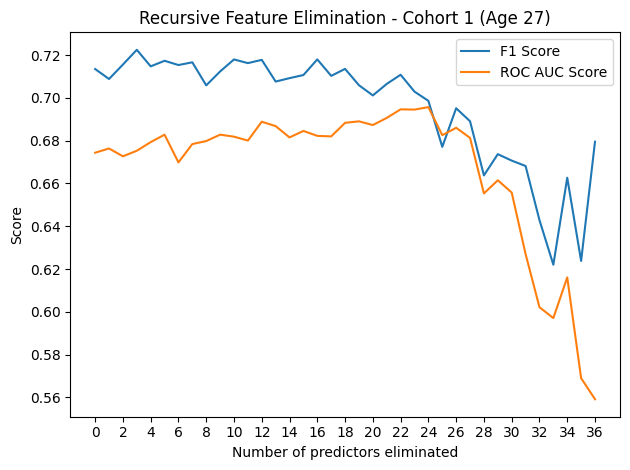

In [145]:
# RFE - X1
X1_rfe = X1_train
feature_names = X1_train.columns.values.tolist()
f1s_X1 = []
roc_aucs_X1 = []
feature_eliminate = []
imps_all = shap_absmean.tolist()

while len(feature_names) > 0:
    # Perform cross-validation
    scores = cross_val_scores(rf_final1, X1_rfe, y1_train)
    f1_avg = np.mean(scores[0])
    roc_auc_avg = np.mean(scores[1])
    
    print(f'F1 Score: {f1_avg}')
    f1s_X1.append(f1_avg)
    
    print(f'ROC AUC Score: {roc_auc_avg}')
    roc_aucs_X1.append(roc_auc_avg)
    
    # Identify least important feature
    least_imp_ind = np.argmin(imps_all)
    print(f'Eliminating feature: {feature_names[least_imp_ind]} (Index: {least_imp_ind})')
    
    # Drop the least important feature
    X1_rfe = X1_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    
    # Remove from feature names and importance list
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    
    print(f'Remaining features: {X1_rfe.shape}')

# Plot the RFE curve for F1 Score
eli_X1 = range(len(f1s_X1))
plt.figure()
# Add plot title
plt.title('Recursive Feature Elimination - Cohort 1 (Age 27)')
plt.plot(eli_X1, f1s_X1, label="F1 Score")
plt.plot(eli_X1, roc_aucs_X1, label="ROC AUC Score")
plt.ylabel('Score')
plt.xlabel('Number of predictors eliminated')
plt.xticks(np.arange(0, len(f1s_X1), step=2))
plt.legend()
plt.tight_layout()
plt.savefig('RFE_plot_X1.png', dpi=1000)
plt.show()

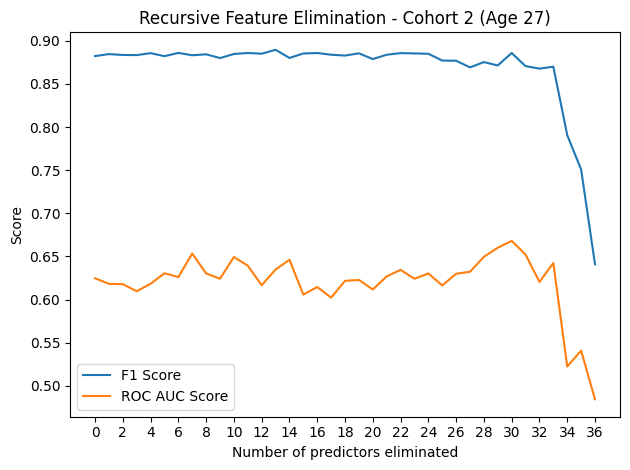

In [144]:
# RFE - X2
X2_rfe = X2_train
feature_names = X2_train.columns.values.tolist()
f1s_X2 = []
roc_aucs_X2 = []
feature_eliminate = []
imps_all = shap_absmean.tolist()

while len(feature_names) > 0:
    # Perform cross-validation
    scores = cross_val_scores(rf_final2, X2_rfe, y2_train)
    f1_avg = np.mean(scores[0])
    roc_auc_avg = np.mean(scores[1])
    
    print(f'F1 Score: {f1_avg}')
    f1s_X2.append(f1_avg)
    
    print(f'ROC AUC Score: {roc_auc_avg}')
    roc_aucs_X2.append(roc_auc_avg)
    
    # Identify least important feature
    least_imp_ind = np.argmin(imps_all)
    print(f'Eliminating feature: {feature_names[least_imp_ind]} (Index: {least_imp_ind})')
    
    # Drop the least important feature
    X2_rfe = X2_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    
    # Remove from feature names and importance list
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    
    print(f'Remaining features: {X2_rfe.shape}')

# Plot the RFE curve for F1 Score
eli_X2 = range(len(f1s_X2))
plt.figure()
# Add plot title
plt.title('Recursive Feature Elimination - Cohort 2 (Age 27)')
plt.plot(eli_X2, f1s_X2, label="F1 Score")
plt.plot(eli_X2, roc_aucs_X2, label="ROC AUC Score")
plt.ylabel('Score')
plt.xlabel('Number of predictors eliminated')
plt.xticks(np.arange(0, len(f1s_X2), step=2))
plt.legend()
plt.tight_layout()
plt.savefig('RFE_plot_X2.png', dpi=1000)
plt.show()

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.34057856980782997
ROC AUC Score: 0.6200437066300671
Eliminating feature: ethni_Turkish.background (Index: 28)
Remaining features: (424, 36)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.327607966457023
ROC AUC Score: 0.6162237011354558
Eliminating feature: denomination_Other (Index: 33)
Remaining features: (424, 35)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.3004724799010513
ROC AUC Score: 0.615982782585873
Eliminating feature: abortion_X1 (Index: 18)
Remaining features: (424, 34)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.3333221146565995
ROC AUC Score: 0.6259421951364345
Eliminating feature: region_Eastern.Germany (Index: 27)
Remaining features: (424, 33)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.3219300540729112
ROC AUC Score: 0.6193093896563548
Eliminating feature: migback_X1 (Index: 18)
Remaining features: (424, 32)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.2911502937109073
ROC AUC Score: 0.6154085398874749
Eliminat

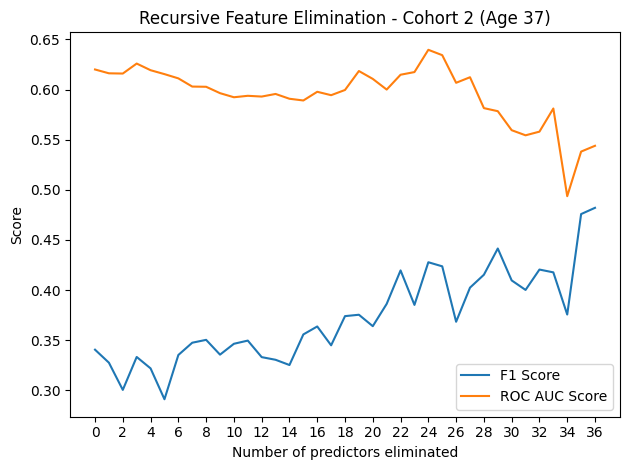

In [146]:
# RFE - X3
X3_rfe = X3_train
feature_names = X3_train.columns.values.tolist()
f1s_X3 = []
roc_aucs_X3 = []
feature_eliminate = []
imps_all = shap_absmean.tolist()

while len(feature_names) > 0:
    # Perform cross-validation
    scores = cross_val_scores(rf_final3, X3_rfe, y3_train)
    f1_avg = np.mean(scores[0])
    roc_auc_avg = np.mean(scores[1])
    
    print(f'F1 Score: {f1_avg}')
    f1s_X3.append(f1_avg)
    
    print(f'ROC AUC Score: {roc_auc_avg}')
    roc_aucs_X3.append(roc_auc_avg)
    
    # Identify least important feature
    least_imp_ind = np.argmin(imps_all)
    print(f'Eliminating feature: {feature_names[least_imp_ind]} (Index: {least_imp_ind})')
    
    # Drop the least important feature
    X3_rfe = X3_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    
    # Remove from feature names and importance list
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    
    print(f'Remaining features: {X3_rfe.shape}')

# Plot the RFE curve for F1 Score
eli_X3 = range(len(f1s_X3))
plt.figure()
# Add plot title
plt.title('Recursive Feature Elimination - Cohort 2 (Age 37)')
plt.plot(eli_X3, f1s_X3, label="F1 Score")
plt.plot(eli_X3, roc_aucs_X3, label="ROC AUC Score")
plt.ylabel('Score')
plt.xlabel('Number of predictors eliminated')
plt.xticks(np.arange(0, len(f1s_X3), step=2))
plt.legend()
plt.tight_layout()
plt.savefig('RFE_plot_X3.png', dpi=1000)
plt.show()

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.6313887579657109
ROC AUC Score: 0.6582727479444772
Eliminating feature: ethni_Turkish.background (Index: 28)
Remaining features: (530, 36)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.6229498313435393
ROC AUC Score: 0.6602578888798001
Eliminating feature: denomination_Other (Index: 33)
Remaining features: (530, 35)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.6266805117033986
ROC AUC Score: 0.6568643542690296
Eliminating feature: abortion_X1 (Index: 18)
Remaining features: (530, 34)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.620781471245273
ROC AUC Score: 0.6580335949140712
Eliminating feature: region_Eastern.Germany (Index: 27)
Remaining features: (530, 33)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.63563195572364
ROC AUC Score: 0.6650010313458671
Eliminating feature: migback_X1 (Index: 18)
Remaining features: (530, 32)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.6390358487001758
ROC AUC Score: 0.6585248153785767
Eliminatin

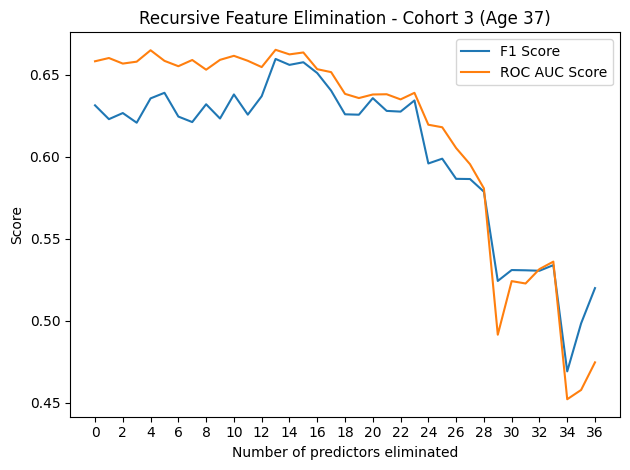

In [147]:
# RFE - X4
X4_rfe = X4_train
feature_names = X4_train.columns.values.tolist()
f1s_X4 = []
roc_aucs_X4 = []
feature_eliminate = []
imps_all = shap_absmean.tolist()

while len(feature_names) > 0:
    # Perform cross-validation
    scores = cross_val_scores(rf_final4, X4_rfe, y4_train)
    f1_avg = np.mean(scores[0])
    roc_auc_avg = np.mean(scores[1])
    
    print(f'F1 Score: {f1_avg}')
    f1s_X4.append(f1_avg)
    
    print(f'ROC AUC Score: {roc_auc_avg}')
    roc_aucs_X4.append(roc_auc_avg)
    
    # Identify least important feature
    least_imp_ind = np.argmin(imps_all)
    print(f'Eliminating feature: {feature_names[least_imp_ind]} (Index: {least_imp_ind})')
    
    # Drop the least important feature
    X4_rfe = X4_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    
    # Remove from feature names and importance list
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    
    print(f'Remaining features: {X4_rfe.shape}')

# Plot the RFE curve for F1 Score
eli_X4 = range(len(f1s_X4))
plt.figure()
# Add plot title
plt.title('Recursive Feature Elimination - Cohort 3 (Age 37)')
plt.plot(eli_X4, f1s_X4, label="F1 Score")
plt.plot(eli_X4, roc_aucs_X4, label="ROC AUC Score")
plt.ylabel('Score')
plt.xlabel('Number of predictors eliminated')
plt.xticks(np.arange(0, len(f1s_X4), step=2))
plt.legend()
plt.tight_layout()
plt.savefig('RFE_plot_X4.png', dpi=1000)
plt.show()

## Shap Bar Plots

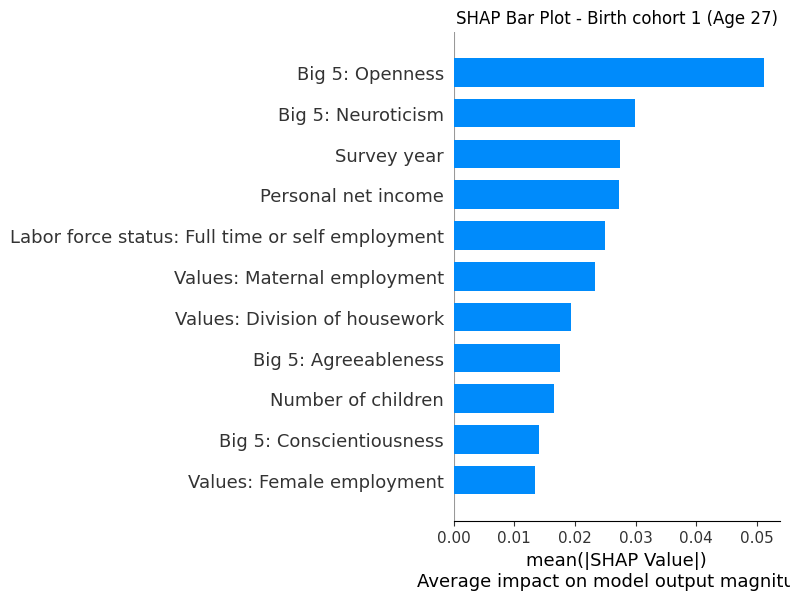

<Figure size 640x480 with 0 Axes>

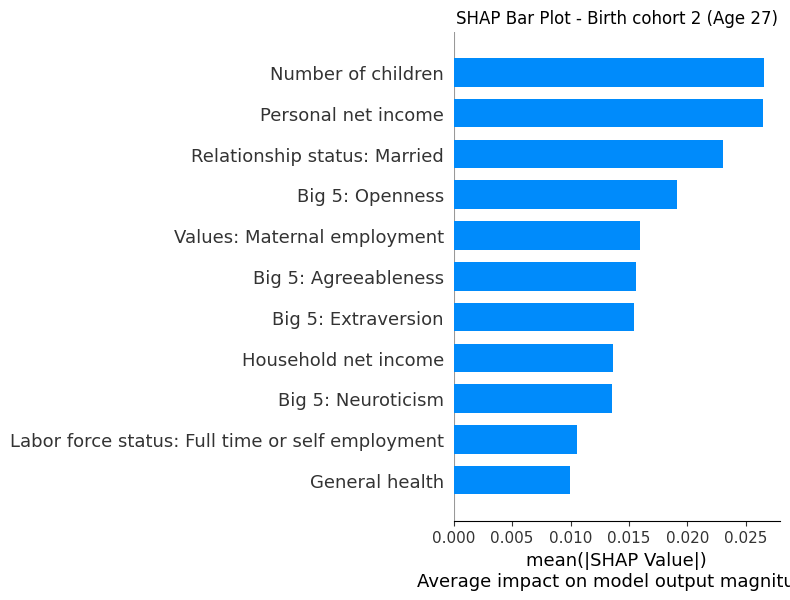

<Figure size 640x480 with 0 Axes>

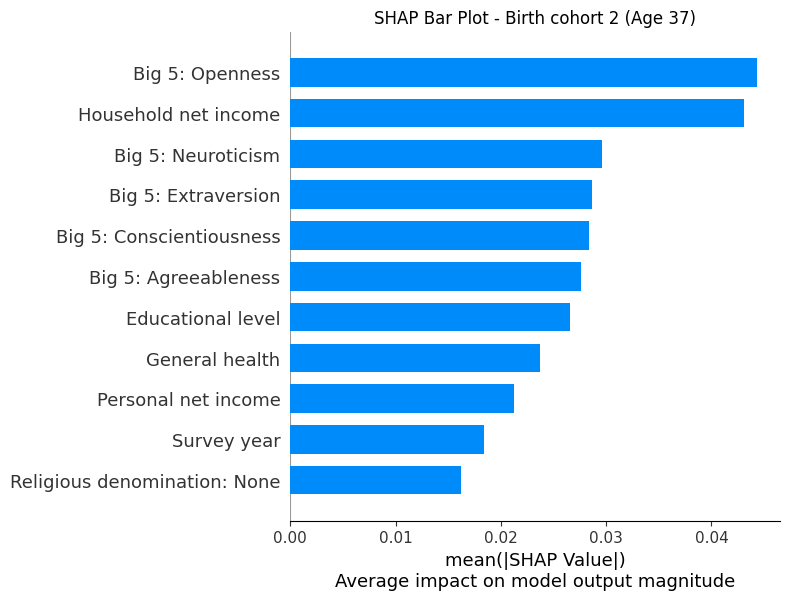

<Figure size 640x480 with 0 Axes>

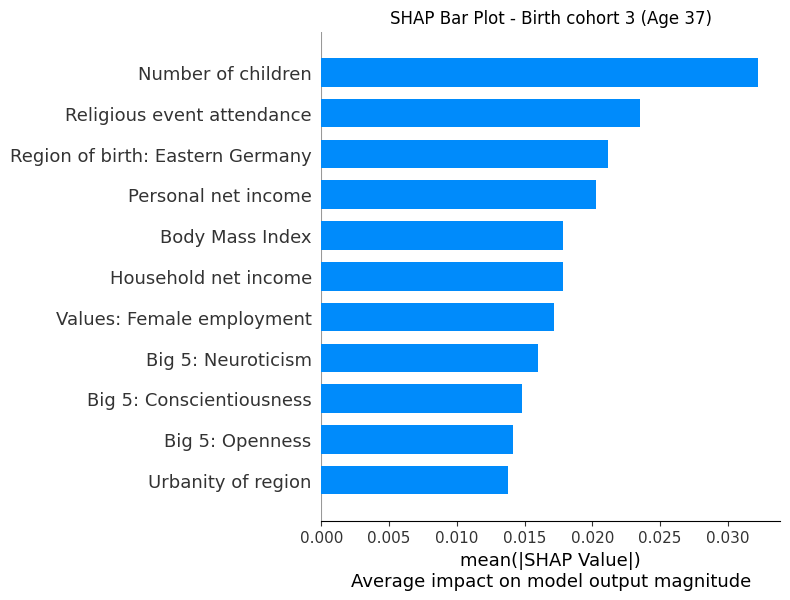

<Figure size 640x480 with 0 Axes>

In [30]:
# Plot SHAP Bar Plot
plt.figure(figsize=(10, 8)) 
plt.title('SHAP Bar Plot - Birth cohort 1 (Age 27)')
shap.summary_plot(shap_values_Tree1[:, :, 1], X1_train, plot_type='bar', 
                  max_display=11, 
                  feature_names= feature_names_list, show=False)
plt.xlabel('mean(|SHAP Value|)\nAverage impact on model output magnitude')
plt.savefig('shap_bar_plot_X1.png')
plt.show()
plt.clf()

plt.figure(figsize=(10, 8)) 
plt.title('SHAP Bar Plot - Birth cohort 2 (Age 27)')
shap.summary_plot(shap_values_Tree2[:, :, 1], X2_train, plot_type='bar', 
                  max_display=11, 
                  feature_names= feature_names_list, show=False)
plt.xlabel('mean(|SHAP Value|)\nAverage impact on model output magnitude')
plt.savefig('shap_bar_plot_X2.png')
plt.show()
plt.clf()

plt.figure(figsize=(10, 8)) 
plt.title('SHAP Bar Plot - Birth cohort 2 (Age 37)')
shap.summary_plot(shap_values_Tree3[:, :, 1], X3_train, 
                  plot_type='bar', 
                  max_display=11, 
                  feature_names= feature_names_list, show=False)
plt.xlabel('mean(|SHAP Value|)\nAverage impact on model output magnitude')
plt.savefig('shap_bar_plot_X3.png')
plt.show()
plt.clf()

plt.figure(figsize=(10, 8)) 
plt.title('SHAP Bar Plot - Birth cohort 3 (Age 37)')
shap.summary_plot(shap_values_Tree4[:, :, 1], X4_train, 
                  plot_type='bar', 
                  max_display=11, 
                  feature_names= feature_names_list, show=False)
plt.xlabel('mean(|SHAP Value|)\nAverage impact on model output magnitude')
plt.savefig('shap_bar_plot_X4.png')
plt.show()
plt.clf()

## Shap Beeswarm Plots

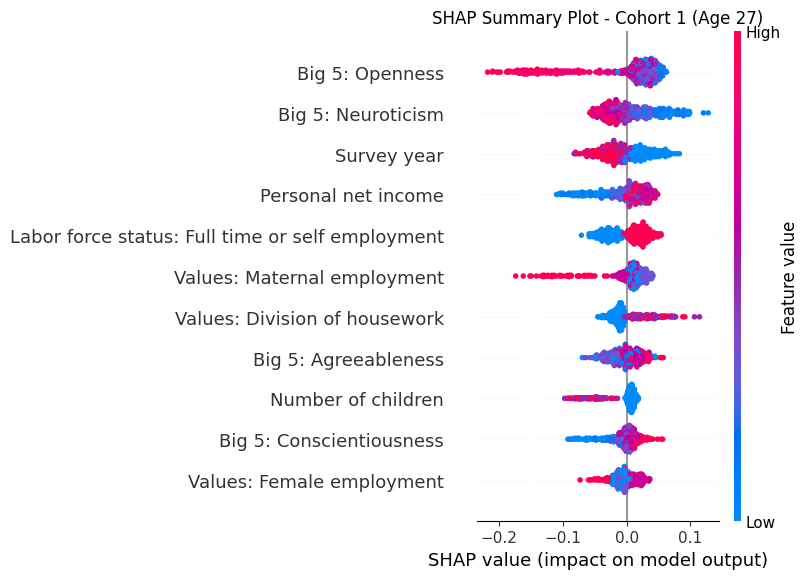

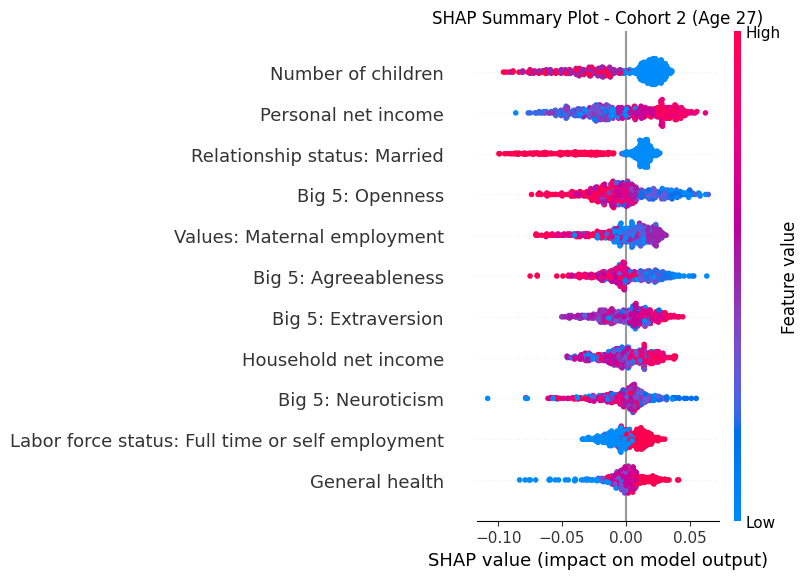

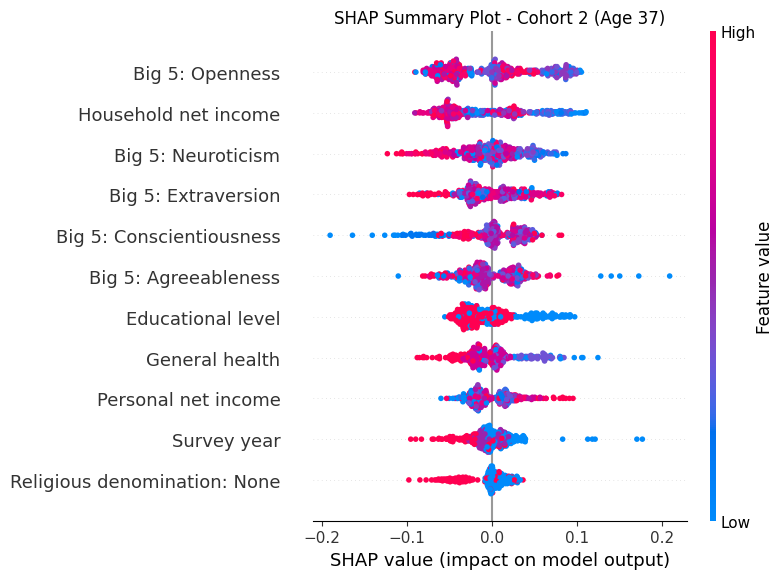

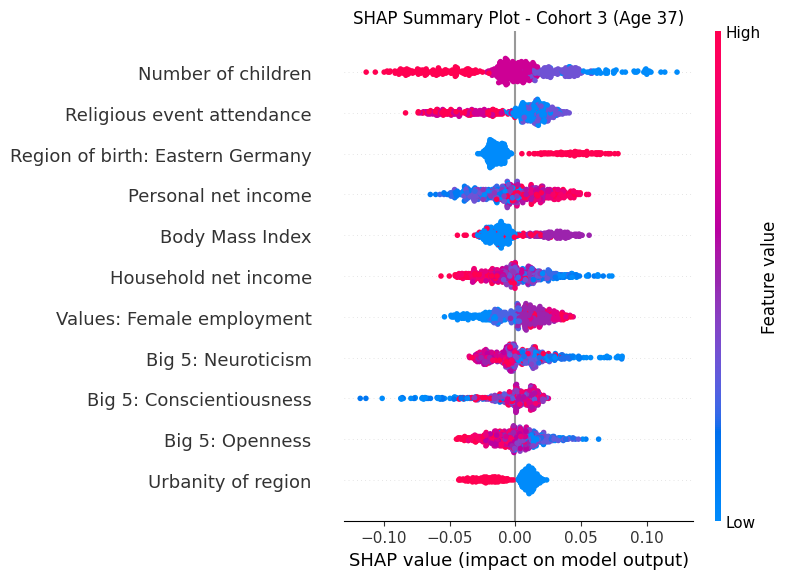

<Figure size 640x480 with 0 Axes>

In [171]:
# Plots SHAP Beeswarm plot
plt.title('SHAP Summary Plot - Cohort 1 (Age 27)')
shap.summary_plot(shap_values_Tree1[:, :, 1], X1_train, 
                  plot_type='dot', 
                  feature_names = feature_names_list,
                  #plot_size=(15, 10),
                  max_display = 11, show=False)
plt.savefig('shap_beeswarm_plot_X1.png')
plt.show()
plt.clf()

plt.title('SHAP Summary Plot - Cohort 2 (Age 27)')
shap.summary_plot(shap_values_Tree2[:, :, 1], X2_train, 
                  plot_type='dot', 
                  feature_names = feature_names_list,
                  #plot_size=(15, 10),
                  max_display = 11, show=False)
plt.savefig('shap_beeswarm_plot_X2.png')
plt.show()
plt.clf()

plt.title('SHAP Summary Plot - Cohort 2 (Age 37)')
shap.summary_plot(shap_values_Tree3[:, :, 1], X3_train, 
                  plot_type='dot', 
                  feature_names = feature_names_list,
                  #plot_size=(15, 10),
                  max_display = 11, show=False)
plt.savefig('shap_beeswarm_plot_X3.png')
plt.show()
plt.clf()

plt.title('SHAP Summary Plot - Cohort 3 (Age 37)')
shap.summary_plot(shap_values_Tree4[:, :, 1], X4_train, 
                  plot_type='dot', 
                  feature_names = feature_names_list,
                  #plot_size=(15, 10),
                  max_display = 11, show=False)
plt.savefig('shap_beeswarm_plot_X4.png')
plt.show()
plt.clf()

## Shap Dependence Plots

Tips: [Plot using string categorical features](https://notebook.community/slundberg/shap/notebooks/plots/dependence_plot)


In [60]:
help(shap.dependence_plot)

Help on function dependence_legacy in module shap.plots._scatter:

dependence_legacy(ind, shap_values=None, features=None, feature_names=None, display_features=None, interaction_index='auto', color='#1E88E5', axis_color='#333333', cmap=None, dot_size=16, x_jitter=0, alpha=1, title=None, xmin=None, xmax=None, ax=None, show=True, ymin=None, ymax=None)
    Create a SHAP dependence plot, colored by an interaction feature.

    Plots the value of the feature on the x-axis and the SHAP value of the same feature
    on the y-axis. This shows how the model depends on the given feature, and is like a
    richer extension of the classical partial dependence plots. Vertical dispersion of the
    data points represents interaction effects. Grey ticks along the y-axis are data
    points where the feature's value was NaN.


    Parameters
    ----------
    ind : int or string
        If this is an int it is the index of the feature to plot. If this is a string it is
        either the name of the 

In [4]:
def plot_dependence_plot(shap_values_Tree, X_data, variable1, variable2, Cohort_Age):
    """
    Plots the SHAP dependence plot for the specified features.

    Parameters:
    shap_values (array): SHAP values from the model.
    features (DataFrame): The feature set used in the model.
    feature1 (str): The first feature to plot.
    feature2 (str): The second feature to plot.
    """
    shap.dependence_plot(variable1, interaction_index= variable2,
                     shap_values = shap_values_Tree[:, :, 1], 
                     features = X_data,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)
    plt.title(f"SHAP Dependence Plot - {Cohort_Age}")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
    plt.show() 

In [ ]:
plot_dependence_plot(shap_values_Tree1, X1_train, 'Number of children', 'Big 5: Agreeableness', 'Cohort 1 (Age 27)')

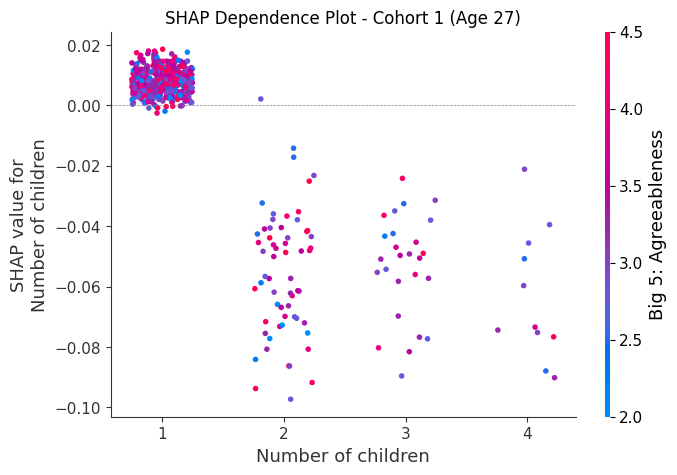

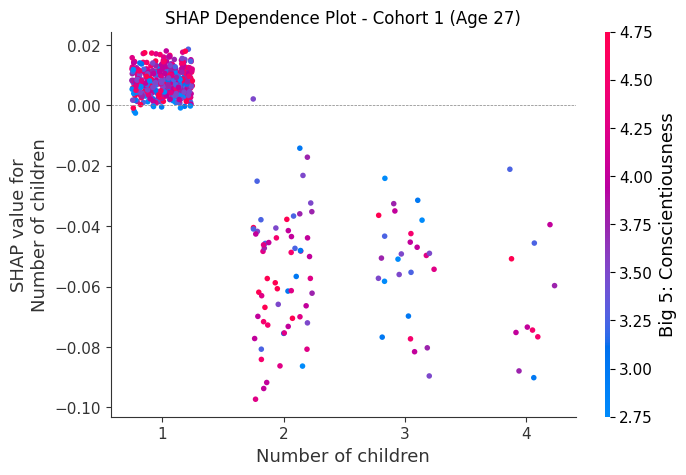

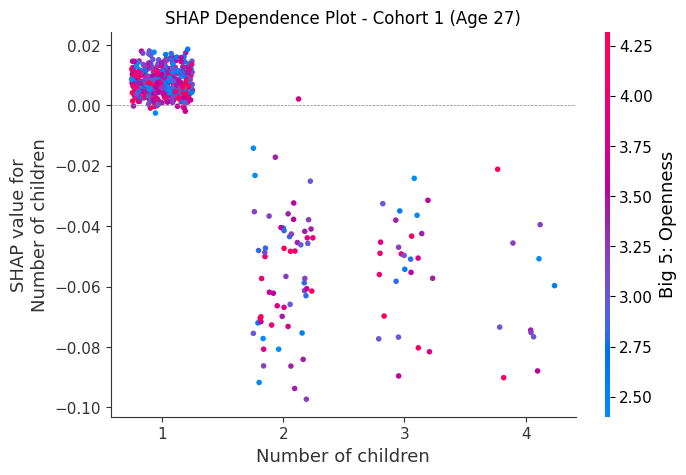

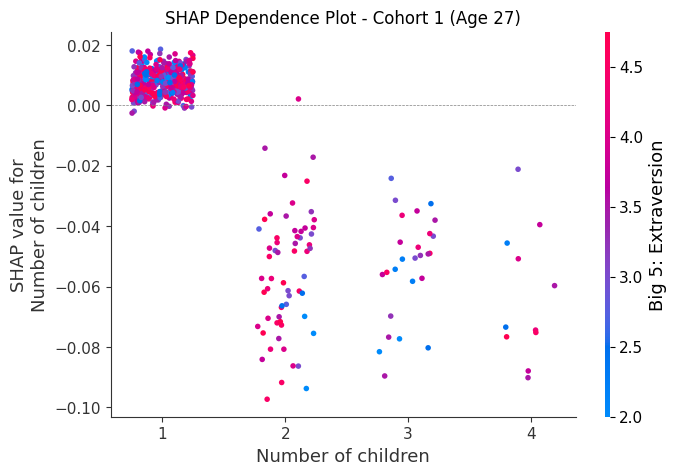

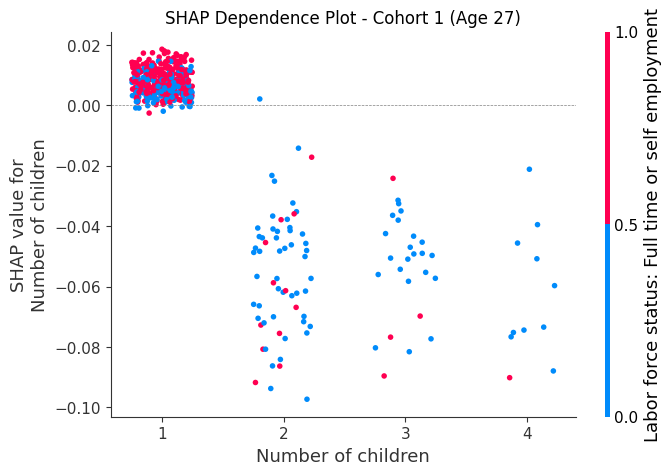

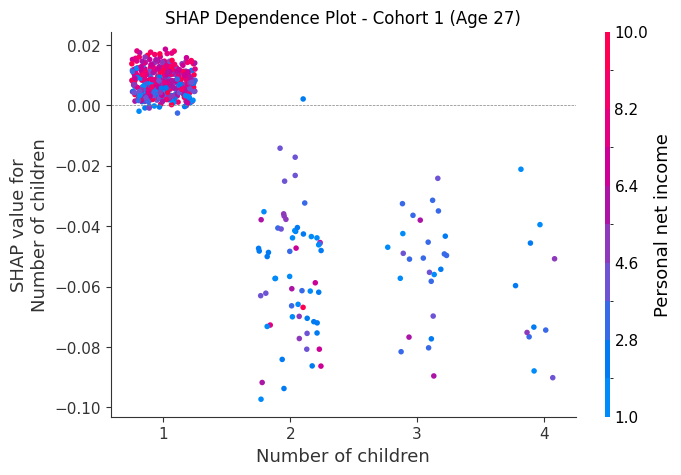

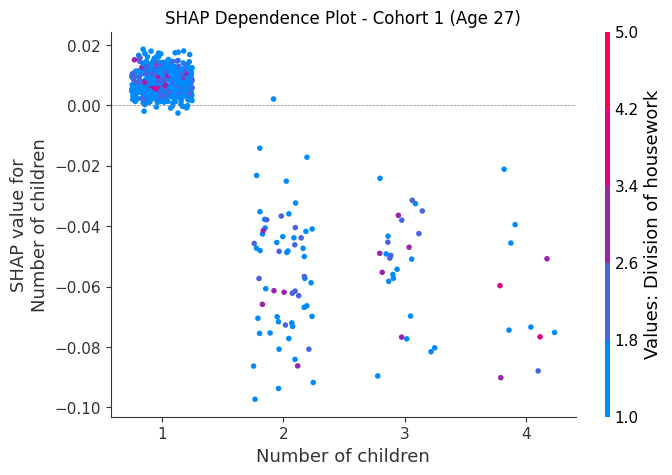

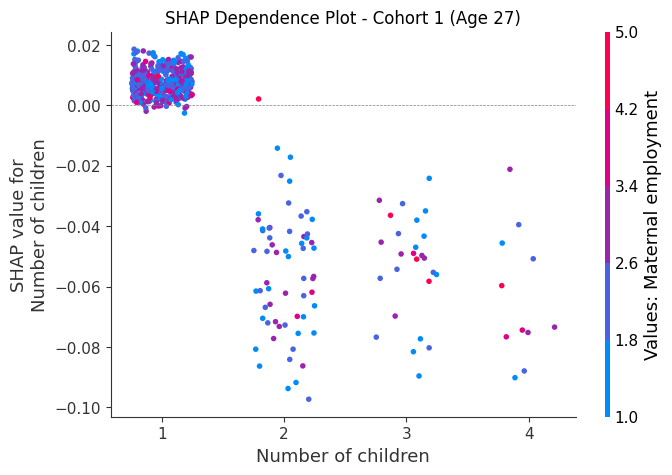

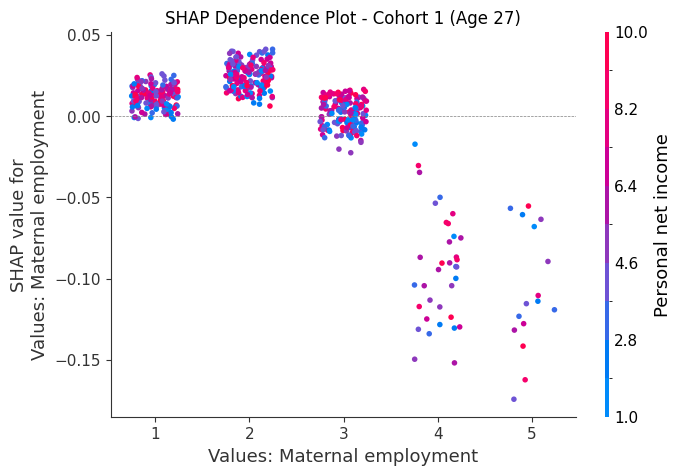

In [163]:
#### DF 1 ####

shap.dependence_plot("Number of children", interaction_index= "Big 5: Agreeableness",
                     shap_values = shap_values_Tree1[:, :, 1], 
                     features = X1_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()


shap.dependence_plot("Number of children", interaction_index= "Big 5: Conscientiousness",
                     shap_values = shap_values_Tree1[:, :, 1], 
                     features = X1_train,
                     feature_names = feature_names_list,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()


shap.dependence_plot("Number of children", interaction_index= "Big 5: Openness",
                     shap_values = shap_values_Tree1[:, :, 1], 
                     features = X1_train,
                     feature_names = feature_names_list,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()


shap.dependence_plot("Number of children", interaction_index= "Big 5: Extraversion",
                    shap_values = shap_values_Tree1[:, :, 1], 
                    features = X1_train,
                    feature_names = feature_names_list,
                    x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()
                 

shap.dependence_plot("Number of children", interaction_index= "Labor force status: Full time or self employment",
                     shap_values = shap_values_Tree1[:, :, 1], 
                     features = X1_train,
                     feature_names = feature_names_list,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Number of children", interaction_index= "Personal net income",
                     shap_values = shap_values_Tree1[:, :, 1], 
                     features = X1_train,
                     feature_names = feature_names_list,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Number of children", interaction_index= "Values: Division of housework",
                     shap_values = shap_values_Tree1[:, :, 1], 
                     features = X1_train,
                     feature_names = feature_names_list,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Number of children", interaction_index= "Values: Maternal employment",
                     shap_values = shap_values_Tree1[:, :, 1], 
                     features = X1_train,
                     feature_names = feature_names_list,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Values: Maternal employment", interaction_index= "Personal net income",
                     shap_values = shap_values_Tree1[:, :, 1], 
                     features = X1_train,
                     feature_names = feature_names_list,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 1 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()




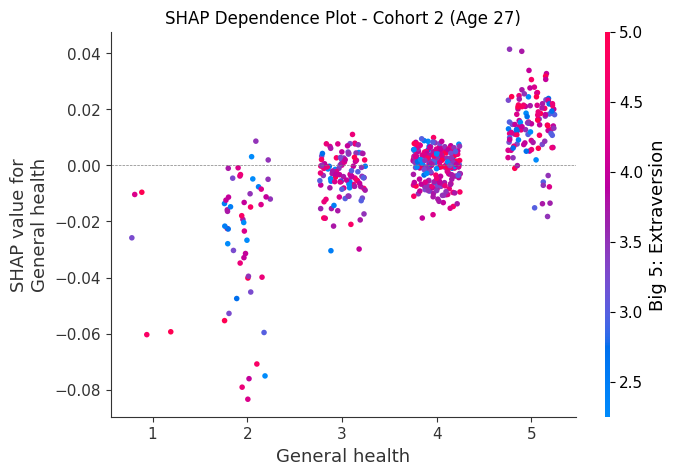

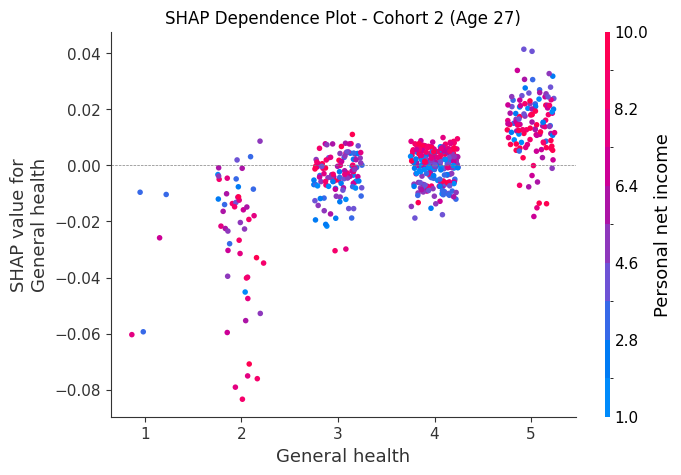

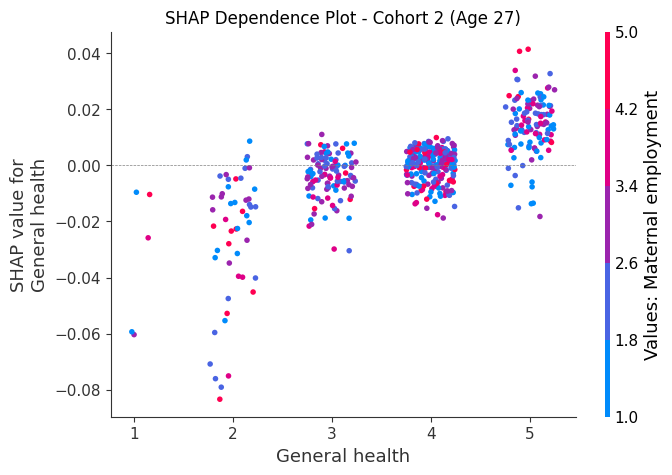

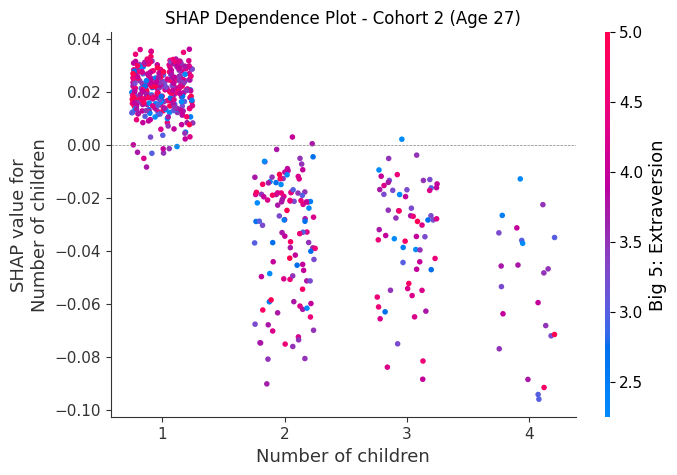

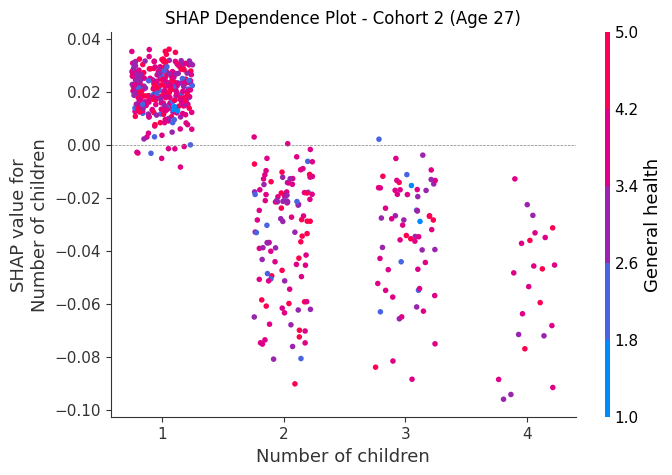

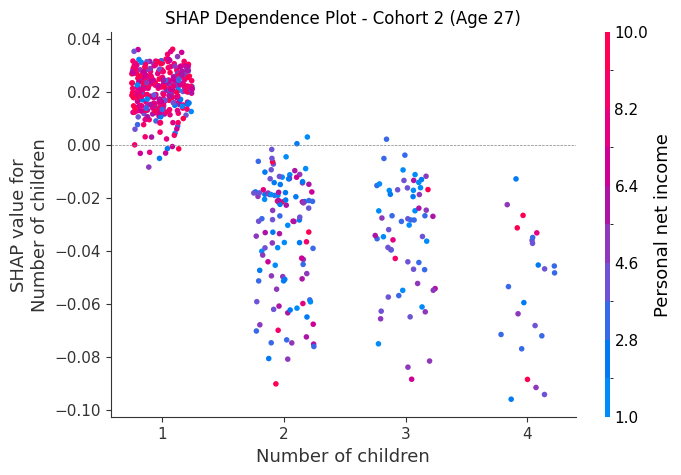

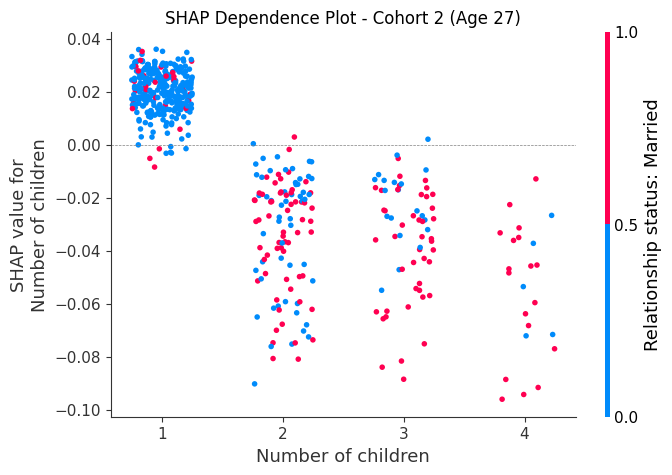

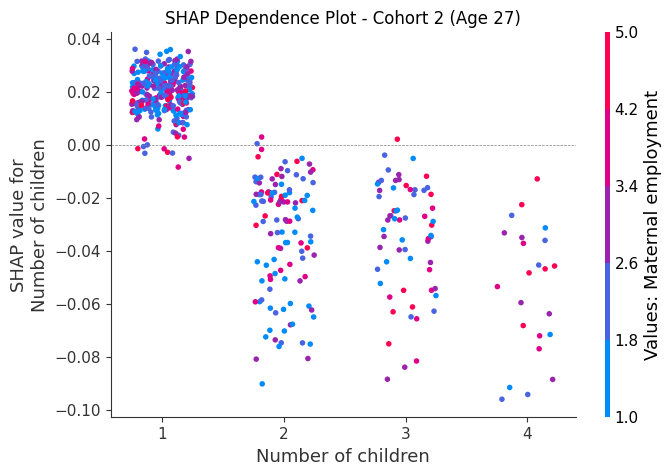

In [161]:
#### DF 2 ####
shap.dependence_plot("General health", interaction_index= "Big 5: Extraversion",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("General health", interaction_index= "Personal net income",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("General health", interaction_index= "Values: Maternal employment",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Number of children", interaction_index= "Big 5: Extraversion",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Number of children", interaction_index= "General health",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Number of children", interaction_index= "Personal net income",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Number of children", interaction_index= "Relationship status: Married",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Number of children", interaction_index= "Values: Maternal employment",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Relationship status: Married", interaction_index= "Big 5: Extraversion",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Relationship status: Married", interaction_index= "General health",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Relationship status: Married", interaction_index= "Personal net income",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Relationship status: Married", interaction_index= "Values: Maternal employment",
                     shap_values = shap_values_Tree2[:, :, 1], 
                     features = X2_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 2 (Age 27)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()


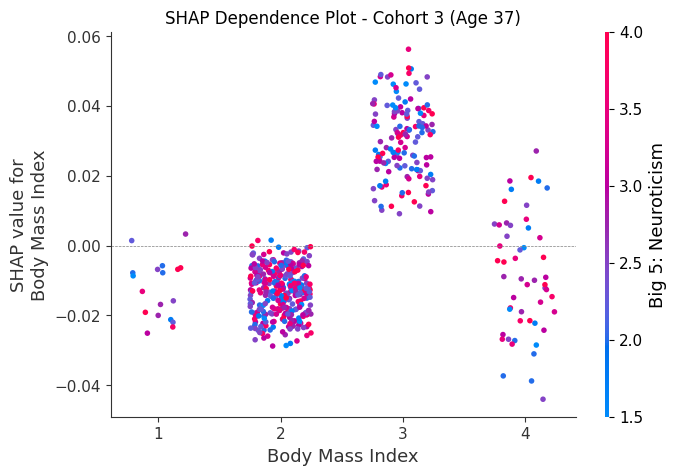

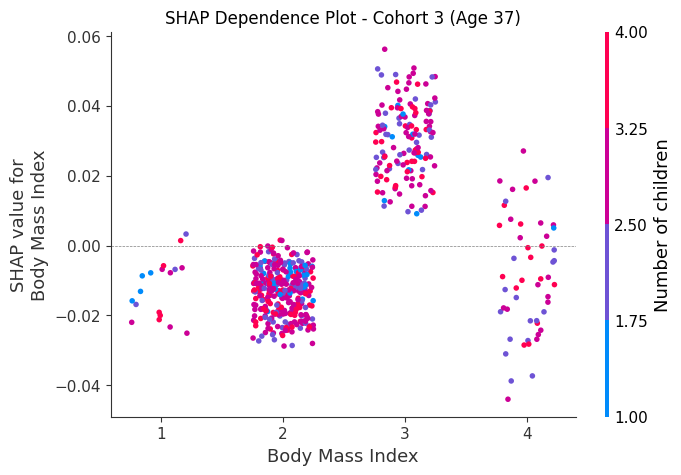

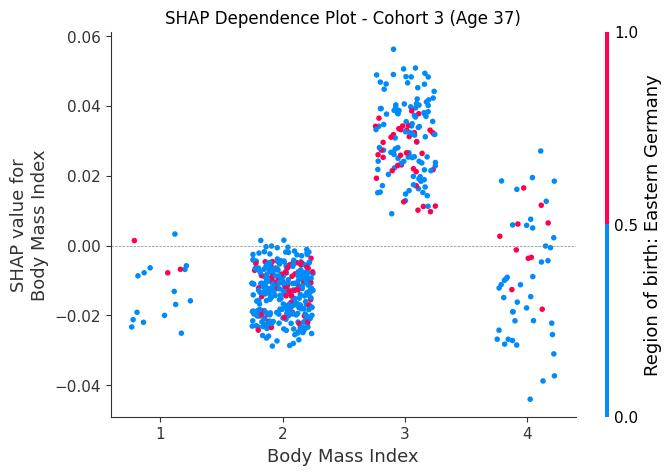

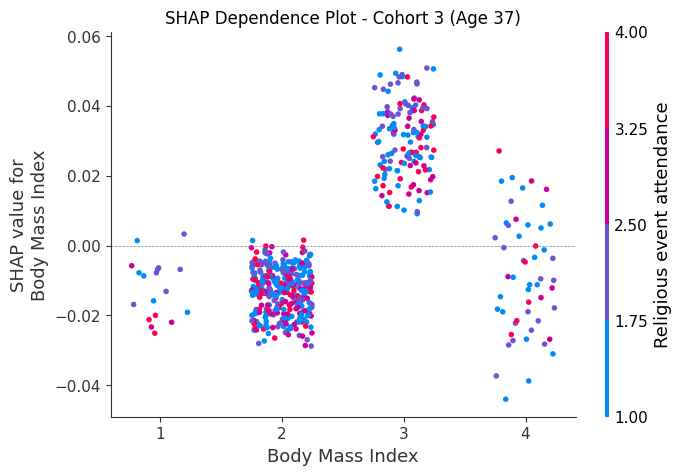

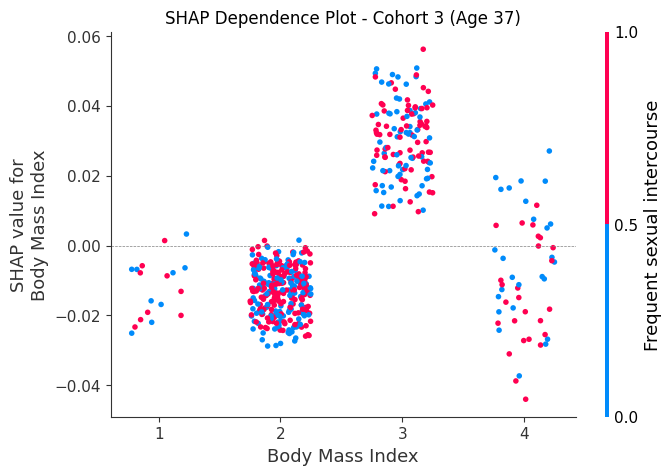

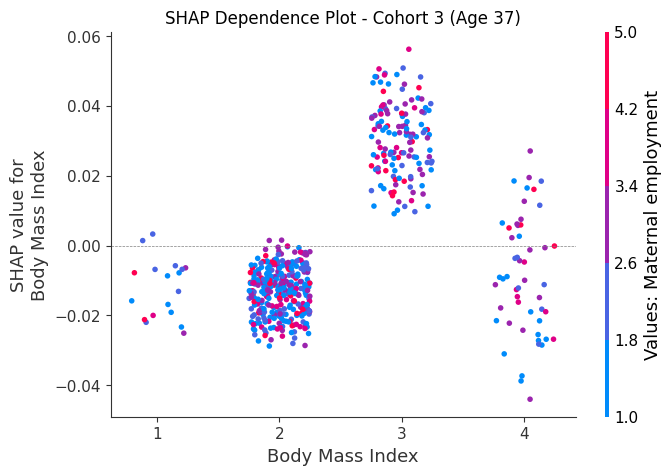

In [170]:
#### DF 4 ####

shap.dependence_plot("Body Mass Index", interaction_index= "Big 5: Neuroticism",
                     shap_values = shap_values_Tree4[:, :, 1], 
                     features = X4_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 3 (Age 37)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Body Mass Index", interaction_index= "Number of children",
                     shap_values = shap_values_Tree4[:, :, 1], 
                     features = X4_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 3 (Age 37)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Body Mass Index", interaction_index= "Region of birth: Eastern Germany",
                     shap_values = shap_values_Tree4[:, :, 1], 
                     features = X4_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 3 (Age 37)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Body Mass Index", interaction_index= "Religious event attendance",
                     shap_values = shap_values_Tree4[:, :, 1], 
                     features = X4_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 3 (Age 37)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Body Mass Index", interaction_index= "Frequent sexual intercourse",
                     shap_values = shap_values_Tree4[:, :, 1], 
                     features = X4_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 3 (Age 37)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()

shap.dependence_plot("Body Mass Index", interaction_index= "Values: Maternal employment",
                     shap_values = shap_values_Tree4[:, :, 1], 
                     features = X4_train,
                     feature_names = feature_names_list,
                     #alpha = 0.75,
                     x_jitter = 0.5, show=False)                       
plt.title("SHAP Dependence Plot - Cohort 3 (Age 37)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
plt.show()